In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

/kaggle/input/attrition-persona-juridica-bbva/DATA_EVALUACIONES_F.txt
/kaggle/input/attrition-persona-juridica-bbva/DATA_STOCK_SUBMIT_SAMPLE.csv
/kaggle/input/attrition-persona-juridica-bbva/DATA_TRANSAC_CANALES_F.txt
/kaggle/input/attrition-persona-juridica-bbva/DATA_ENDEUDAMIENTO_F.txt
/kaggle/input/attrition-persona-juridica-bbva/DATA_COTIZACIONES_DESEMBOLSO_F.txt
/kaggle/input/attrition-persona-juridica-bbva/DATA_SOLICITUDES_F.txt
/kaggle/input/attrition-persona-juridica-bbva/DATA_PRODUCTOS_BCO_F.txt
/kaggle/input/attrition-persona-juridica-bbva/DATA_STOCK_VARS_TRAIN_F.txt
/kaggle/input/attrition-persona-juridica-bbva/DATA_STOCK_VARS_TEST_F.txt
/kaggle/input/attrition-persona-juridica-bbva/diccionario de datos_actualizado/DATA_TRANSAC_CANALES.xlsx
/kaggle/input/attrition-persona-juridica-bbva/diccionario de datos_actualizado/DATA_STOCK_VARS.xlsx
/kaggle/input/attrition-persona-juridica-bbva/diccionario de datos_actualizado/DATA_SOLICITUDES.xlsx
/kaggle/input/attrition-persona-jurid

In [2]:
from pylab import *
import pandas as pd
from pandas.plotting import scatter_matrix
import seaborn as sns
from scipy import stats
import random
import sys 
import gc

from sklearn.model_selection import train_test_split, cross_val_score, KFold, StratifiedShuffleSplit, ShuffleSplit, StratifiedKFold
from sklearn.metrics import roc_curve, auc, precision_recall_curve
from sklearn.preprocessing import minmax_scale, MinMaxScaler, StandardScaler, RobustScaler, QuantileTransformer
from sklearn.metrics import recall_score, precision_score, r2_score, roc_auc_score
from sklearn.svm import SVC
from pandas.plotting import scatter_matrix
from sklearn.ensemble import GradientBoostingClassifier , RandomForestClassifier ,  RandomForestRegressor
from xgboost import XGBClassifier, XGBRegressor
from scipy import spatial
from sklearn.neural_network import MLPClassifier
from sklearn.manifold import TSNE
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression, ElasticNet, Lasso
from sklearn.feature_selection import RFE, RFECV
from sklearn.ensemble import AdaBoostClassifier
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.cluster import KMeans
from sklearn.preprocessing import PolynomialFeatures
from sklearn.decomposition import PCA 
from sklearn.naive_bayes import BernoulliNB
from sklearn.model_selection import RandomizedSearchCV
from sklearn.tree import DecisionTreeClassifier
from scipy.optimize import curve_fit
from scipy.optimize import curve_fit
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

def year_month_2_dt(MES):
    y = trunc(MES/100)
    m = mod(MES,100)
    m = array(m)
    m_ = zeros(m.size)
    for i, mm in enumerate(m):
        if mm<3:
            m_[i] = mm-2 + 12
            y.iloc[i] = y.iloc[i]-1
        else:
            m_[i] = mm-2
    date = pd.to_datetime(pd.DataFrame({'year':y,'month':m_, 'day':y*0 +1})) 
    return date

def year_month_dt(MES):
    y = trunc(MES/100)
    m = mod(MES,100)
    date = pd.to_datetime(pd.DataFrame({'year':y,'month':m, 'day':y*0 +1})) 
    return date




def year_month_2(MES):
    y = trunc(MES/100)
    m = mod(MES,100)
    m = array(m)
    m_ = zeros(m.size)
    for i, mm in enumerate(m):
        if mm<3:
            m_[i] = mm-2 + 12
            y.iloc[i] = y.iloc[i]-1
        else:
            m_[i] = mm-2
    date = y*100 + m_
    return date.astype('int')

def MES_to_X(MES):
    y = trunc(MES/100)
    m = mod(MES,100)
    x = (y-2017)*12 + m
    return x







def find_corr(df, cc = .7, CMAP = 'viridis', N =1, method = 'pearson'):
    """df : DataFrame """
    CORR = df.corr(method = method)
    CORR[abs(CORR)< cc ] =0
    CC = CORR.copy()
    IC = []
    #CC.fillna(1, inplace = True)
    for i, II in enumerate(CC.index):
    #    print( (CC.iloc[i, i:]>0).sum() )
    #    print(CC.iloc[i, i:]>0 )
        if (  abs( CC.iloc[i, i:] ) >0 ).sum()>1:
            IC.append(II)
    IC = IC +    CORR.columns[CORR.isna().sum() == df.columns.size].tolist()  
    INC = list(CC.columns)
    [ INC.remove(c) for c in IC]
    figure(N, figsize = (12,6))
    subplot(1,2,1),  sns.heatmap(CORR, cmap = CMAP)
    CC = df[INC].corr()
    #CC[abs(CC)<cc] = 0
    subplot(1,2,2), sns.heatmap(CC, cmap = CMAP)
    tight_layout()
    show()
    return INC





def KVS_TEST(dfX, y, pv0 = .005):
    """Kolmogorov-Smirnov TEST """
    names = []
    PV = []
    ST = []
    #Z = dfX.copy()
    for n in dfX.columns:
        X0 = dfX[n] ;
        z0 = X0[y==0].values
        z1 = X0[y==1].values
        st, pv = stats.ks_2samp(z0, z1)
        if pv <pv0:
            names.append(n)
            PV.append(pv)
            ST.append(st)
    return names, PV, ST


This approximation gets ideas of works: "Distributed and parallel time series feature extraction for industrial big data applications" and "Time Series Feature Extraction on basis of Scalable Hypothesis tests"

https://www.sciencedirect.com/science/article/pii/S0925231218304843


https://arxiv.org/pdf/1610.07717.pdf

In [3]:
df_producto = pd.read_csv('/kaggle/input/attrition-persona-juridica-bbva/DATA_PRODUCTOS_BCO_F.txt', index_col = 'ID_CLIENTE')
df_stock_train= pd.read_csv('/kaggle/input/attrition-persona-juridica-bbva/DATA_STOCK_VARS_TRAIN_F.txt', index_col = 'ID_CLIENTE')
df_stock_test= pd.read_csv('/kaggle/input/attrition-persona-juridica-bbva/DATA_STOCK_VARS_TEST_F.txt', index_col = 'ID_CLIENTE')
print(df_producto.shape, df_stock_train.shape , df_stock_test.shape)
df_producto.head()

/opt/conda/lib/python3.6/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


(1739335, 83) (73661, 19) (26338, 19)


,MES,NU_CTA_AHORRO,RGO_SDO_AHORRO,RGO_MARGEN_AHORRO,NU_CTA_CTE,RGO_SDO_CTE,RGO_MARGEN_CTE,NU_CTA_FMUTUO,RGO_SDO_FMUTUO,RGO_MARGEN_FMUTUO,...,RGO_SDO_CMPL,RGO_MARGEN_CMPL,NU_CTA_CARTERA,RGO_SDO_CARTERA,RGO_MARGEN_CARTERA,NU_CTA_STANDBY,RGO_SDO_STANDBY,RGO_MARGEN_STANDBY,RGO_PASIVO,RGO_ACTIVO
ID_CLIENTE,,,,,,,,,,,,,,,,,,,,,
44765,201708,1,11,10,0,3,9,0,6,13,...,6,11,0,6,13,0,6,11,6,2
32317,201708,1,11,10,0,3,9,0,6,13,...,6,11,0,6,13,0,6,11,6,2
59201,201708,1,11,10,0,3,9,0,6,13,...,6,11,0,6,13,0,6,11,6,2
13541,201709,2,11,10,0,5,9,0,19,13,...,6,11,0,6,13,0,6,11,6,2
32375,201710,1,11,10,0,3,9,0,6,13,...,6,11,0,6,13,0,6,11,6,2


In [4]:

MES_T0 = pd.concat([df_stock_train.MES_T0, df_stock_test.MES_T0], axis = 0)
MES_T0.head()



ID_CLIENTE
48117    201808
87846    201808
89372    201808
87164    201804
13922    201804
Name: MES_T0, dtype: int64

# PRODUCTO DATASET

In [5]:
df_producto.head()

,MES,NU_CTA_AHORRO,RGO_SDO_AHORRO,RGO_MARGEN_AHORRO,NU_CTA_CTE,RGO_SDO_CTE,RGO_MARGEN_CTE,NU_CTA_FMUTUO,RGO_SDO_FMUTUO,RGO_MARGEN_FMUTUO,...,RGO_SDO_CMPL,RGO_MARGEN_CMPL,NU_CTA_CARTERA,RGO_SDO_CARTERA,RGO_MARGEN_CARTERA,NU_CTA_STANDBY,RGO_SDO_STANDBY,RGO_MARGEN_STANDBY,RGO_PASIVO,RGO_ACTIVO
ID_CLIENTE,,,,,,,,,,,,,,,,,,,,,
44765,201708,1,11,10,0,3,9,0,6,13,...,6,11,0,6,13,0,6,11,6,2
32317,201708,1,11,10,0,3,9,0,6,13,...,6,11,0,6,13,0,6,11,6,2
59201,201708,1,11,10,0,3,9,0,6,13,...,6,11,0,6,13,0,6,11,6,2
13541,201709,2,11,10,0,5,9,0,19,13,...,6,11,0,6,13,0,6,11,6,2
32375,201710,1,11,10,0,3,9,0,6,13,...,6,11,0,6,13,0,6,11,6,2


In [6]:
df_producto = pd.concat([df_producto, MES_T0.loc[df_producto.index] ], axis = 1)
df_producto.head()


,MES,NU_CTA_AHORRO,RGO_SDO_AHORRO,RGO_MARGEN_AHORRO,NU_CTA_CTE,RGO_SDO_CTE,RGO_MARGEN_CTE,NU_CTA_FMUTUO,RGO_SDO_FMUTUO,RGO_MARGEN_FMUTUO,...,RGO_MARGEN_CMPL,NU_CTA_CARTERA,RGO_SDO_CARTERA,RGO_MARGEN_CARTERA,NU_CTA_STANDBY,RGO_SDO_STANDBY,RGO_MARGEN_STANDBY,RGO_PASIVO,RGO_ACTIVO,MES_T0
ID_CLIENTE,,,,,,,,,,,,,,,,,,,,,
44765,201708,1,11,10,0,3,9,0,6,13,...,11,0,6,13,0,6,11,6,2,201808
32317,201708,1,11,10,0,3,9,0,6,13,...,11,0,6,13,0,6,11,6,2,201805
59201,201708,1,11,10,0,3,9,0,6,13,...,11,0,6,13,0,6,11,6,2,201902
13541,201709,2,11,10,0,5,9,0,19,13,...,11,0,6,13,0,6,11,6,2,201804
32375,201710,1,11,10,0,3,9,0,6,13,...,11,0,6,13,0,6,11,6,2,201805


In [7]:
print(df_producto.shape)
# works with months minor a month to evaluate

df_producto = df_producto[df_producto.MES<df_producto.MES_T0]
print(df_producto.shape)
df_producto.head()

(1739335, 84)
(1204825, 84)


,MES,NU_CTA_AHORRO,RGO_SDO_AHORRO,RGO_MARGEN_AHORRO,NU_CTA_CTE,RGO_SDO_CTE,RGO_MARGEN_CTE,NU_CTA_FMUTUO,RGO_SDO_FMUTUO,RGO_MARGEN_FMUTUO,...,RGO_MARGEN_CMPL,NU_CTA_CARTERA,RGO_SDO_CARTERA,RGO_MARGEN_CARTERA,NU_CTA_STANDBY,RGO_SDO_STANDBY,RGO_MARGEN_STANDBY,RGO_PASIVO,RGO_ACTIVO,MES_T0
ID_CLIENTE,,,,,,,,,,,,,,,,,,,,,
44765,201708,1,11,10,0,3,9,0,6,13,...,11,0,6,13,0,6,11,6,2,201808
32317,201708,1,11,10,0,3,9,0,6,13,...,11,0,6,13,0,6,11,6,2,201805
59201,201708,1,11,10,0,3,9,0,6,13,...,11,0,6,13,0,6,11,6,2,201902
13541,201709,2,11,10,0,5,9,0,19,13,...,11,0,6,13,0,6,11,6,2,201804
32375,201710,1,11,10,0,3,9,0,6,13,...,11,0,6,13,0,6,11,6,2,201805


In [8]:

df = pd.DataFrame()
df['name'] = df_producto.columns
df['counts'] = 0
CC = df_producto.columns
for k, c in enumerate(CC):
    #print(c, df_producto[c].unique().size)
    df['counts'].loc[k] = df_producto[c].unique().size
df.head()



/opt/conda/lib/python3.6/site-packages/pandas/core/indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


,name,counts
0,MES,19
1,NU_CTA_AHORRO,13
2,RGO_SDO_AHORRO,20
3,RGO_MARGEN_AHORRO,20
4,NU_CTA_CTE,16


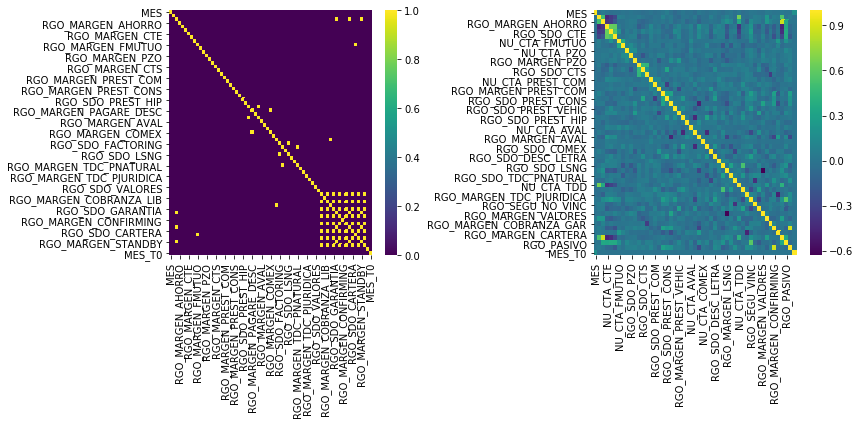

51


,NU_CTA_PREST_VEHIC_0,NU_CTA_PREST_VEHIC_1,NU_CTA_PREST_VEHIC_2,NU_CTA_PREST_VEHIC_3,NU_CTA_PREST_HIP_0,NU_CTA_PREST_HIP_1,NU_CTA_PREST_HIP_2,NU_CTA_PREST_HIP_3,NU_CTA_DESC_LETRA_0,NU_CTA_DESC_LETRA_1,...,NU_CTA_VALORES_2,NU_CTA_VALORES_3,NU_CTA_COBRANZA_LIB_0,NU_CTA_COBRANZA_LIB_1,NU_CTA_COBRANZA_LIB_2,NU_CTA_COBRANZA_GAR_0,NU_CTA_COBRANZA_GAR_1,NU_CTA_COBRANZA_GAR_2,NU_CTA_CONFIRMING_0,NU_CTA_CONFIRMING_1
ID_CLIENTE,,,,,,,,,,,,,,,,,,,,,
44765,1,0,0,0,1,0,0,0,1,0,...,0,0,1,0,0,1,0,0,1,0
32317,1,0,0,0,1,0,0,0,1,0,...,0,0,1,0,0,1,0,0,1,0
59201,1,0,0,0,1,0,0,0,1,0,...,0,0,1,0,0,1,0,0,1,0
13541,1,0,0,0,1,0,0,0,1,0,...,0,0,1,0,0,1,0,0,1,0
32375,1,0,0,0,1,0,0,0,1,0,...,0,0,1,0,0,1,0,0,1,0


In [9]:
names = df[df.counts>4].name.to_list()
namesD = df[(df.counts>1) &(df.counts<=4)].name.to_list()
df_producto_D = df_producto[namesD]
df_producto = df_producto[names]

a = find_corr(df_producto, cc = .95)
print(len(a))
df_producto = df_producto[a]

A = pd.get_dummies(df_producto_D.astype('str') )
A.head()



In [10]:

A = A.groupby('ID_CLIENTE').sum()
print(A.shape, df_producto_D.shape)
A.head()

df_producto_D = A
del A

(99063, 39) (1204825, 11)


In [11]:
df_producto.MES = MES_to_X(df_producto.MES)
df_producto.MES_T0 = MES_to_X(df_producto.MES_T0)


In [12]:

IX = intersect1d(df_stock_train.index , df_producto.index)
y_train = df_stock_train.loc[IX].FUGA_3M
print(len(IX), len(y_train))

72928 72928


# FUNCTION TO SEPARATE TIME SERIES BY 4 MOTHS

In [13]:
def mean_dates_4(df, namecol = '_'):
    df0 = df.groupby('ID_CLIENTE').mean()
    df0.drop(columns = ['MES', 'MES_T0'], inplace = True)
    CC = df0.columns
    CC = [c + namecol  for c in CC]
    df0.columns = CC
    #######################3333
    A = df.loc[(df.MES > df.MES_T0-5) ]
    A.drop(columns = ['MES', 'MES_T0'], inplace = True)
    A = A.groupby('ID_CLIENTE').mean()
    CC = A.columns
    CC = [c + namecol + '41' for c in CC]
    A.columns = CC
    df1 = A
    #####################3
    A = df.loc[(df.MES<=df.MES_T0-5) & (df.MES>df.MES_T0-9) ]
    A.drop(columns = ['MES', 'MES_T0'], inplace = True)
    A = A.groupby('ID_CLIENTE').mean()
    CC = A.columns
    CC = [c + namecol + '42' for c in CC]
    A.columns = CC
    df2 = A
    #######################################################
    A = df.loc[(df.MES>df.MES_T0-13) & (df.MES<=df.MES_T0-9) ]
    A.drop(columns = ['MES', 'MES_T0'], inplace = True)
    A = A.groupby('ID_CLIENTE').mean()
    CC = A.columns
    CC = [c + namecol + '43' for c in CC]
    A.columns = CC
    df3 = A
    DF = pd.concat([df0, df1, df2, df3], axis =  1)
    del df0, df1, df2, df3, A
    return DF

def mean_test(df0, IX, y_train, namecol = '_', pv0 = 1e-5 ):

    df = mean_dates_4(df0, namecol = namecol)
    
    names, pv, st = KVS_TEST(df.loc[IX], y_train , pv0 = pv0)
    u = find_corr(df[names], cc= .9)
    print( len(u) )
    df = df[u]
    return df 


In [14]:
dz = df_producto.reset_index().set_index(['ID_CLIENTE','MES', 'MES_T0'])
dz.head()

,,,NU_CTA_AHORRO,RGO_MARGEN_AHORRO,NU_CTA_CTE,RGO_SDO_CTE,RGO_MARGEN_CTE,NU_CTA_FMUTUO,RGO_SDO_FMUTUO,NU_CTA_PZO,RGO_SDO_PZO,RGO_MARGEN_PZO,...,RGO_SEGU_NO_VINC,RGO_SDO_VALORES,RGO_MARGEN_VALORES,RGO_MARGEN_COBRANZA_LIB,RGO_MARGEN_COBRANZA_GAR,RGO_MARGEN_CONFIRMING,RGO_MARGEN_CARTERA,RGO_MARGEN_STANDBY,RGO_PASIVO,RGO_ACTIVO
ID_CLIENTE,MES,MES_T0,,,,,,,,,,,,,,,,,,,,,
44765,8.0,20.0,1,10,0,3,9,0,6,0,10,2,...,10,14,16,15,3,2,13,11,6,2
32317,8.0,17.0,1,10,0,3,9,0,6,0,10,2,...,10,14,16,15,3,2,13,11,6,2
59201,8.0,26.0,1,10,0,3,9,0,6,0,10,2,...,10,14,16,15,3,2,13,11,6,2
13541,9.0,16.0,2,10,0,5,9,0,19,0,12,2,...,10,14,16,15,3,2,13,11,6,2
32375,10.0,17.0,1,10,0,3,9,0,6,0,10,2,...,10,14,16,15,3,2,13,11,6,2


# SOME USEFUL  TIME SERIES TRANSFORMATIONS

In [15]:
####### diff

df = dz.copy()
dff1 = reduce_mem_usage( (df -df.groupby(['ID_CLIENTE']).shift(1)) )
dff_sh = reduce_mem_usage( (df.groupby(['ID_CLIENTE']).shift(1)/df ) )
dflog = reduce_mem_usage( df.apply(np.log) )


dff_sh.replace([np.inf, -np.inf], np.nan, inplace = True)
dff_sh.fillna(1, inplace = True)
dff1.fillna(0, inplace = True)
dflog.replace([np.inf, -np.inf], np.nan, inplace = True)
dflog.fillna(1, inplace = True)

Mem. usage decreased to 120.25 Mb (73.7% reduction)
Mem. usage decreased to 196.09 Mb (57.2% reduction)
Mem. usage decreased to 196.09 Mb (57.2% reduction)


In [16]:
df_producto.head()

,MES,NU_CTA_AHORRO,RGO_MARGEN_AHORRO,NU_CTA_CTE,RGO_SDO_CTE,RGO_MARGEN_CTE,NU_CTA_FMUTUO,RGO_SDO_FMUTUO,NU_CTA_PZO,RGO_SDO_PZO,...,RGO_SDO_VALORES,RGO_MARGEN_VALORES,RGO_MARGEN_COBRANZA_LIB,RGO_MARGEN_COBRANZA_GAR,RGO_MARGEN_CONFIRMING,RGO_MARGEN_CARTERA,RGO_MARGEN_STANDBY,RGO_PASIVO,RGO_ACTIVO,MES_T0
ID_CLIENTE,,,,,,,,,,,,,,,,,,,,,
44765,8.0,1,10,0,3,9,0,6,0,10,...,14,16,15,3,2,13,11,6,2,20.0
32317,8.0,1,10,0,3,9,0,6,0,10,...,14,16,15,3,2,13,11,6,2,17.0
59201,8.0,1,10,0,3,9,0,6,0,10,...,14,16,15,3,2,13,11,6,2,26.0
13541,9.0,2,10,0,5,9,0,19,0,12,...,14,16,15,3,2,13,11,6,2,16.0
32375,10.0,1,10,0,3,9,0,6,0,10,...,14,16,15,3,2,13,11,6,2,17.0


In [17]:
dz = mean_dates_4(df_producto)
print(dz.shape, df_producto.shape)

/opt/conda/lib/python3.6/site-packages/pandas/core/frame.py:4102: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


(99063, 196) (1204825, 51)


151 (99063, 196)


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log10
  This is separate from the ipykernel package so we can avoid doing imports until


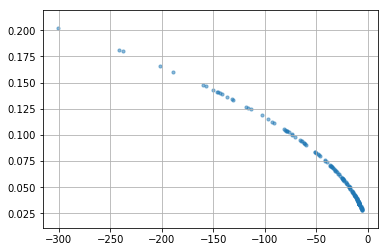

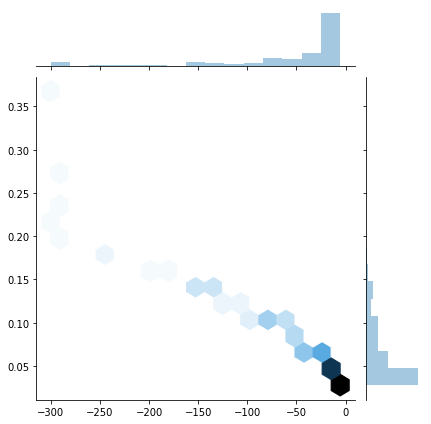

In [18]:
names, PV, ST = KVS_TEST(dz.loc[IX], y_train, pv0 = 1e-5)
print(len(names), dz.shape)
scatter(log10(array(PV)) , ( array(ST)) , alpha = .5, s = 10), grid()
sns.jointplot(x = log10( array(PV)+1e-300), y = ( array(ST)   ), kind="hex")

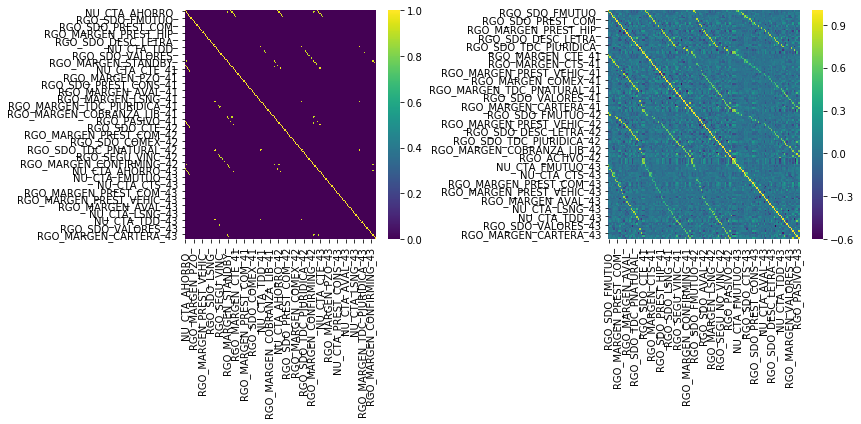

134


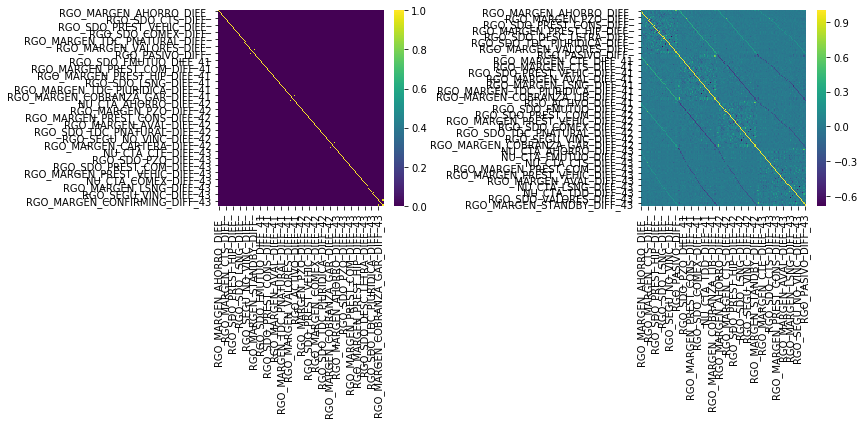

163


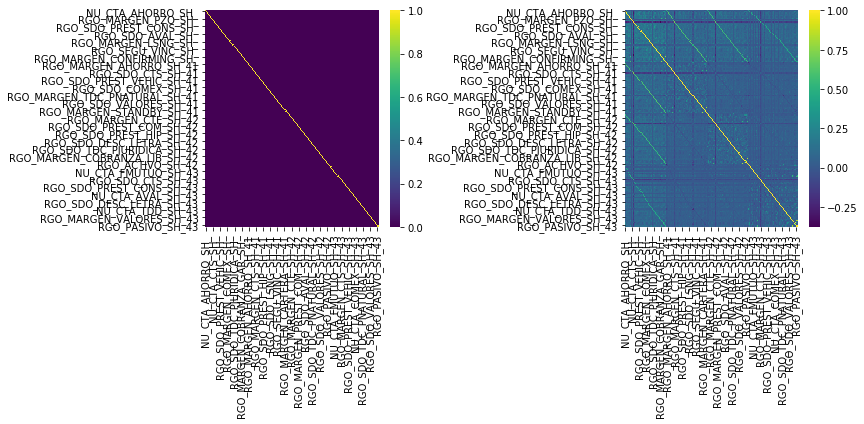

170


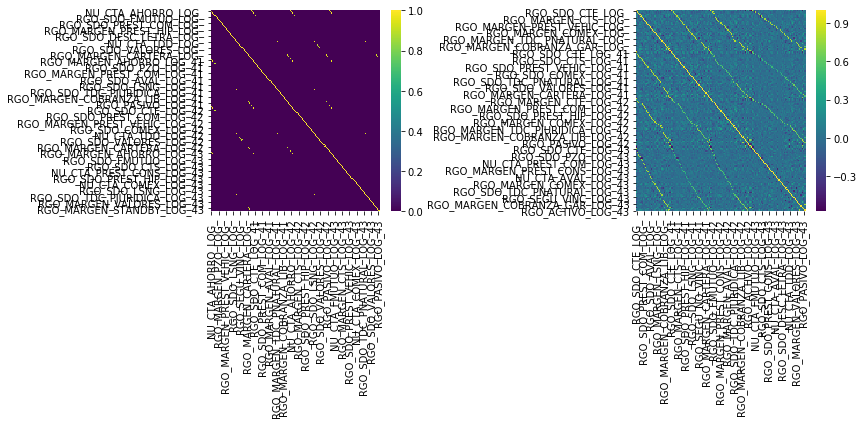

146


In [19]:
dfA = mean_test(df_producto, IX, y_train, namecol = '_', pv0 = 1e-3 )
dfD = mean_test(dff1.reset_index().set_index('ID_CLIENTE'), IX, y_train, namecol = '_DIFF_', pv0 = 1e-3)
dfSH = mean_test(dff_sh.reset_index().set_index('ID_CLIENTE'), IX, y_train, namecol = '_SH_', pv0 = 1e-3 )
dfLOG = mean_test( dflog.reset_index().set_index('ID_CLIENTE') , IX, y_train, namecol = '_LOG_', pv0 = 1e-3 )

del  dff1, dff_sh, dflog, dz, df


In [20]:
DF = pd.concat([dfA, dfD, dfSH, dfLOG], axis = 1)
del dfA, dfD, dfSH, dfLOG
DF.head()

,RGO_SDO_FMUTUO_,RGO_SDO_PZO_,RGO_MARGEN_PZO_,RGO_SDO_CTS_,RGO_MARGEN_CTS_,RGO_SDO_PREST_COM_,RGO_MARGEN_PREST_COM_,RGO_SDO_PREST_CONS_,RGO_MARGEN_PREST_CONS_,RGO_MARGEN_PREST_VEHIC_,...,RGO_SEGU_NO_VINC_LOG_43,RGO_SDO_VALORES_LOG_43,RGO_MARGEN_VALORES_LOG_43,RGO_MARGEN_COBRANZA_LIB_LOG_43,RGO_MARGEN_COBRANZA_GAR_LOG_43,RGO_MARGEN_CONFIRMING_LOG_43,RGO_MARGEN_CARTERA_LOG_43,RGO_MARGEN_STANDBY_LOG_43,RGO_PASIVO_LOG_43,RGO_ACTIVO_LOG_43
ID_CLIENTE,,,,,,,,,,,,,,,,,,,,,
1,8.000000,2.000000,11.000000,19.000000,19.000000,11.454545,2.000000,3.727273,13.000000,15.000000,...,1.098633,2.708984,2.302734,0.693359,2.996094,2.773438,2.564453,1.386719,2.302734,2.773438
2,11.076923,9.615385,7.923077,12.076923,10.230769,13.692308,16.307692,9.461538,5.846154,2.461538,...,1.609375,1.690430,2.484375,2.904297,1.762695,1.386719,2.861328,2.503906,1.979492,1.386719
3,10.375000,9.375000,12.250000,6.250000,7.375000,12.875000,9.750000,9.625000,9.625000,13.875000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,15.500000,10.250000,16.000000,6.500000,12.250000,8.750000,13.500000,8.000000,8.250000,9.250000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,20.000000,13.000000,9.000000,14.000000,16.000000,20.000000,20.000000,12.000000,4.153846,13.769231,...,2.996094,2.224609,2.708984,2.515625,1.791992,0.000000,2.470703,1.459961,2.753906,2.996094


In [21]:
df = df_producto.reset_index().set_index(['ID_CLIENTE','MES', 'MES_T0'])

dfSTD =  df.groupby('ID_CLIENTE').std()
dfK = df.groupby(['ID_CLIENTE']).apply( pd.DataFrame.kurt )
dfSK = df.groupby(['ID_CLIENTE']).apply( pd.DataFrame.skew )

print(dfSTD.shape, dfK.shape, dfSK.shape)



(99063, 49) (99063, 49) (99063, 49)


In [22]:
gc.collect()
names, pv, st = KVS_TEST(dfSTD.loc[IX], y_train,  pv0 = 1e-3 )
dfSTD = dfSTD[names]
print(len(names))

names, pv, st = KVS_TEST(dfK.loc[IX], y_train,  pv0 = 1e-3 )
dfK = dfK[names] 
print(len(names))

names, pv, st = KVS_TEST(dfSK.loc[IX], y_train,  pv0 = 1e-3 )
dfSK = dfSK[names]
print(len(names))

41
40
40


In [23]:
cc = [ c + '_STD' for c in dfSTD.columns]
dfSTD.columns = cc

cc = [ c + '_KURT' for c in dfK.columns]
dfK.columns = cc

cc = [ c + '_SKEW' for c in dfSK.columns]
dfSK.columns = cc

dfST = pd.concat([dfSTD, dfK, dfSK], axis = 1)
del dfSTD, dfK, dfSK

dfST.head()

,NU_CTA_AHORRO_STD,RGO_MARGEN_AHORRO_STD,RGO_SDO_CTE_STD,RGO_MARGEN_CTE_STD,RGO_SDO_FMUTUO_STD,RGO_SDO_PZO_STD,RGO_MARGEN_PZO_STD,NU_CTA_CTS_STD,RGO_SDO_CTS_STD,RGO_MARGEN_CTS_STD,...,RGO_SEGU_NO_VINC_SKEW,RGO_SDO_VALORES_SKEW,RGO_MARGEN_VALORES_SKEW,RGO_MARGEN_COBRANZA_LIB_SKEW,RGO_MARGEN_COBRANZA_GAR_SKEW,RGO_MARGEN_CONFIRMING_SKEW,RGO_MARGEN_CARTERA_SKEW,RGO_MARGEN_STANDBY_SKEW,RGO_PASIVO_SKEW,RGO_ACTIVO_SKEW
ID_CLIENTE,,,,,,,,,,,,,,,,,,,,,
1,0.0,2.412091,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,-3.316625,0.000000,0.000000,0.000000,0.000000,0.000000
2,0.0,2.025479,2.385856,2.106157,3.094660,6.551571,5.837544,0.0,6.237809,4.603510,...,3.605551,-1.760248,3.605551,-1.671343,3.128150,-0.246607,-0.875713,2.178717,2.178717,-0.383807
3,0.0,1.851640,5.012484,3.248626,5.730557,6.093029,8.241879,0.0,5.418223,6.926914,...,-2.068883,0.648374,0.048221,-1.018096,-0.610964,0.432043,-0.676243,-0.898676,-0.040409,0.414976
4,0.0,5.965177,2.828427,4.716991,3.000000,5.377422,3.464102,0.0,4.358899,5.909033,...,-0.854563,1.007682,1.779179,1.468391,-1.039695,1.779179,-1.414214,-1.658524,-1.494105,1.846278
5,0.0,0.000000,0.688737,0.751068,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,...,0.000000,1.882060,0.000000,-0.445089,0.000000,0.000000,-0.946212,-0.848679,-0.018540,0.000000


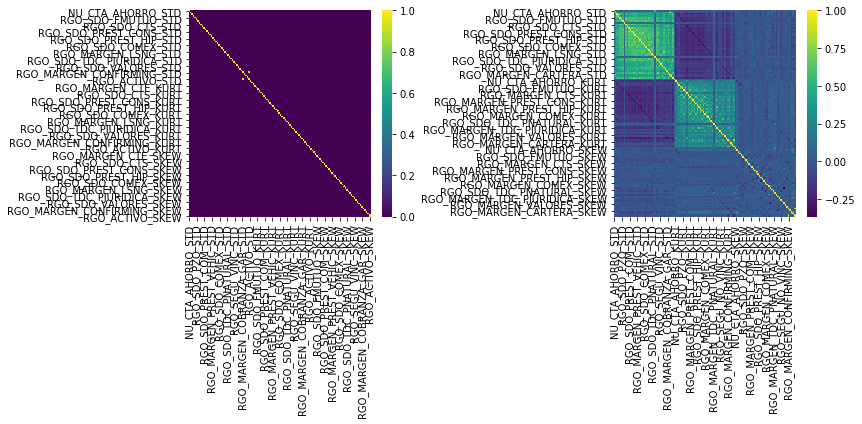

120


In [24]:
names = find_corr(dfST, cc= .9)
print(len(names))
dfST  = dfST[names]

In [25]:
DF_PRODUCTO = pd.concat([DF, dfST], axis = 1)
del dfST, df, df_producto
DF_PRODUCTO.head()

,RGO_SDO_FMUTUO_,RGO_SDO_PZO_,RGO_MARGEN_PZO_,RGO_SDO_CTS_,RGO_MARGEN_CTS_,RGO_SDO_PREST_COM_,RGO_MARGEN_PREST_COM_,RGO_SDO_PREST_CONS_,RGO_MARGEN_PREST_CONS_,RGO_MARGEN_PREST_VEHIC_,...,RGO_SEGU_NO_VINC_SKEW,RGO_SDO_VALORES_SKEW,RGO_MARGEN_VALORES_SKEW,RGO_MARGEN_COBRANZA_LIB_SKEW,RGO_MARGEN_COBRANZA_GAR_SKEW,RGO_MARGEN_CONFIRMING_SKEW,RGO_MARGEN_CARTERA_SKEW,RGO_MARGEN_STANDBY_SKEW,RGO_PASIVO_SKEW,RGO_ACTIVO_SKEW
ID_CLIENTE,,,,,,,,,,,,,,,,,,,,,
1,8.000000,2.000000,11.000000,19.000000,19.000000,11.454545,2.000000,3.727273,13.000000,15.000000,...,0.000000,0.000000,0.000000,0.000000,-3.316625,0.000000,0.000000,0.000000,0.000000,0.000000
2,11.076923,9.615385,7.923077,12.076923,10.230769,13.692308,16.307692,9.461538,5.846154,2.461538,...,3.605551,-1.760248,3.605551,-1.671343,3.128150,-0.246607,-0.875713,2.178717,2.178717,-0.383807
3,10.375000,9.375000,12.250000,6.250000,7.375000,12.875000,9.750000,9.625000,9.625000,13.875000,...,-2.068883,0.648374,0.048221,-1.018096,-0.610964,0.432043,-0.676243,-0.898676,-0.040409,0.414976
4,15.500000,10.250000,16.000000,6.500000,12.250000,8.750000,13.500000,8.000000,8.250000,9.250000,...,-0.854563,1.007682,1.779179,1.468391,-1.039695,1.779179,-1.414214,-1.658524,-1.494105,1.846278
5,20.000000,13.000000,9.000000,14.000000,16.000000,20.000000,20.000000,12.000000,4.153846,13.769231,...,0.000000,1.882060,0.000000,-0.445089,0.000000,0.000000,-0.946212,-0.848679,-0.018540,0.000000


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log10
  after removing the cwd from sys.path.


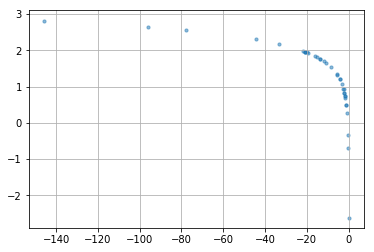

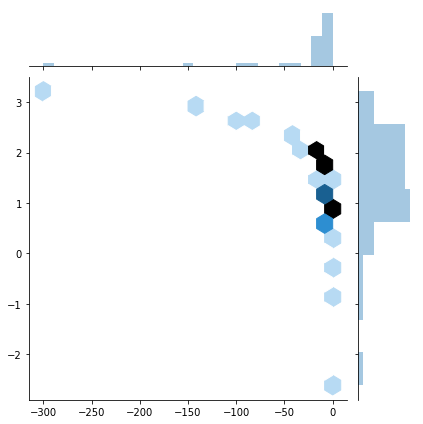

In [26]:
#CHI SQUARE TEST
from sklearn.feature_selection import  chi2
a, b = chi2(df_producto_D.loc[IX], y_train)
scatter(log10(b), log10(a), alpha = .5, s = 10), grid()
sns.jointplot(x = log10(b+1e-300), y = log10(a + 1e-300), kind="hex")



In [27]:
COLCD = df_producto_D.columns[a>1e2]
print(len(COLCD))
df_producto_D = df_producto_D[COLCD]
df_producto_D.head()

6


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in greater
  """Entry point for launching an IPython kernel.


,NU_CTA_TDC_PNATURAL_0,NU_CTA_TDC_PJURIDICA_1,NU_CTA_DOMI_1,NU_CTA_NOMINA_0,NU_CTA_NOMINA_1,NU_CTA_VALORES_1
ID_CLIENTE,,,,,,
1,11,0,0,11,0,0
2,13,0,0,13,0,0
3,8,0,0,8,0,0
4,4,0,0,4,0,0
5,13,13,0,13,0,0


In [28]:
DF_PRODUCTO = pd.concat([DF_PRODUCTO, df_producto_D], axis = 1)
del df_producto_D
DF_PRODUCTO.head()

,RGO_SDO_FMUTUO_,RGO_SDO_PZO_,RGO_MARGEN_PZO_,RGO_SDO_CTS_,RGO_MARGEN_CTS_,RGO_SDO_PREST_COM_,RGO_MARGEN_PREST_COM_,RGO_SDO_PREST_CONS_,RGO_MARGEN_PREST_CONS_,RGO_MARGEN_PREST_VEHIC_,...,RGO_MARGEN_CARTERA_SKEW,RGO_MARGEN_STANDBY_SKEW,RGO_PASIVO_SKEW,RGO_ACTIVO_SKEW,NU_CTA_TDC_PNATURAL_0,NU_CTA_TDC_PJURIDICA_1,NU_CTA_DOMI_1,NU_CTA_NOMINA_0,NU_CTA_NOMINA_1,NU_CTA_VALORES_1
ID_CLIENTE,,,,,,,,,,,,,,,,,,,,,
1,8.000000,2.000000,11.000000,19.000000,19.000000,11.454545,2.000000,3.727273,13.000000,15.000000,...,0.000000,0.000000,0.000000,0.000000,11,0,0,11,0,0
2,11.076923,9.615385,7.923077,12.076923,10.230769,13.692308,16.307692,9.461538,5.846154,2.461538,...,-0.875713,2.178717,2.178717,-0.383807,13,0,0,13,0,0
3,10.375000,9.375000,12.250000,6.250000,7.375000,12.875000,9.750000,9.625000,9.625000,13.875000,...,-0.676243,-0.898676,-0.040409,0.414976,8,0,0,8,0,0
4,15.500000,10.250000,16.000000,6.500000,12.250000,8.750000,13.500000,8.000000,8.250000,9.250000,...,-1.414214,-1.658524,-1.494105,1.846278,4,0,0,4,0,0
5,20.000000,13.000000,9.000000,14.000000,16.000000,20.000000,20.000000,12.000000,4.153846,13.769231,...,-0.946212,-0.848679,-0.018540,0.000000,13,13,0,13,0,0


# ENDEUDAMIENTO DATASETS

In [29]:
df_endeudamiento = pd.read_csv('/kaggle/input/attrition-persona-juridica-bbva/DATA_ENDEUDAMIENTO_F.txt', index_col = 'ID_CLIENTE')
gc.collect()
df_endeudamiento.head()


/opt/conda/lib/python3.6/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


,MES,CD_BANCO,ST_CREDITO,RGO_SDGRANDES_EMP,RGO_SDMEDIANAS_EMP,RGO_SDPEQUENIAS_EMP,RGO_SDMICROEMPRESA,RGO_SDDIRECTO,RGO_SDINDIRECTO,RGO_SDTOTAL,...,RGO_SDFACTORING,RGO_SDAVALES,RGO_SDCARTFIANZA,RGO_SDCREDITO,RGO_SDACEPBANCA,RGO_SDGTIA_HIPOTEC,RGO_SDGTIA_PREFE,RGO_SD_NOPREFE,RGO_SD_SINLEASING,RGO_SDLEA_PEM
ID_CLIENTE,,,,,,,,,,,,,,,,,,,,,
97597,201809,231,1.0,19,15,19,6,17,11,17,...,20,4,12,6,18,7,9,3,17,4
76119,201804,106,1.0,19,15,19,6,17,11,17,...,20,4,12,6,18,7,9,3,17,4
50080,201805,228,1.0,19,15,19,6,17,11,17,...,20,4,12,6,18,7,9,3,17,4
98183,201803,107,1.0,19,15,19,6,17,11,17,...,20,4,12,6,18,7,9,3,17,4
17109,201901,2,1.0,19,15,19,6,17,11,17,...,20,4,12,6,18,7,9,3,17,4


In [30]:
df = pd.DataFrame()
df['name'] = df_endeudamiento.columns
df['counts'] = 0
CC = df_endeudamiento.columns
for k, c in enumerate(CC):
    #print(c, df_producto[c].unique().size)
    df['counts'].loc[k] = df_endeudamiento[c].unique().size
df.sort_values('counts')[0:40]

/opt/conda/lib/python3.6/site-packages/pandas/core/indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


,name,counts
2,ST_CREDITO,5
0,MES,19
22,RGO_SD_NOPREFE,20
21,RGO_SDGTIA_PREFE,20
20,RGO_SDGTIA_HIPOTEC,20
19,RGO_SDACEPBANCA,20
18,RGO_SDCREDITO,20
17,RGO_SDCARTFIANZA,20
16,RGO_SDAVALES,20
15,RGO_SDFACTORING,20


In [31]:
print(df_endeudamiento.shape)
df_endeudamiento = pd.concat([df_endeudamiento, MES_T0.loc[df_endeudamiento.index] ], axis = 1)
# works with months minor a month to evaluate
df_endeudamiento = df_endeudamiento[df_endeudamiento.MES<df_endeudamiento.MES_T0]
print(df_endeudamiento.shape)
df_endeudamiento.head()

(3071165, 25)
(2174946, 26)


,MES,CD_BANCO,ST_CREDITO,RGO_SDGRANDES_EMP,RGO_SDMEDIANAS_EMP,RGO_SDPEQUENIAS_EMP,RGO_SDMICROEMPRESA,RGO_SDDIRECTO,RGO_SDINDIRECTO,RGO_SDTOTAL,...,RGO_SDAVALES,RGO_SDCARTFIANZA,RGO_SDCREDITO,RGO_SDACEPBANCA,RGO_SDGTIA_HIPOTEC,RGO_SDGTIA_PREFE,RGO_SD_NOPREFE,RGO_SD_SINLEASING,RGO_SDLEA_PEM,MES_T0
ID_CLIENTE,,,,,,,,,,,,,,,,,,,,,
76119,201804,106,1.0,19,15,19,6,17,11,17,...,4,12,6,18,7,9,3,17,4,201805
50080,201805,228,1.0,19,15,19,6,17,11,17,...,4,12,6,18,7,9,3,17,4,201808
98183,201803,107,1.0,19,15,19,6,17,11,17,...,4,12,6,18,7,9,3,17,4,201807
85467,201801,72,1.0,19,15,19,6,17,11,17,...,4,12,6,18,7,9,3,17,4,201808
59930,201707,106,1.0,19,15,19,6,17,11,17,...,4,12,6,18,7,9,3,17,4,201901


In [32]:
df_endeudamiento.MES = MES_to_X(df_endeudamiento.MES)
df_endeudamiento.MES_T0 = MES_to_X(df_endeudamiento.MES_T0)

IX = intersect1d(df_stock_train.index , df_endeudamiento.index)
y_train = df_stock_train.loc[IX].FUGA_3M
print(len(IX), len(y_train))

51754 51754


In [33]:

dz = df_endeudamiento.reset_index().set_index(['ID_CLIENTE','MES', 'MES_T0'])
dz.drop(columns = 'CD_BANCO', inplace = True)
dz.head()

,,,ST_CREDITO,RGO_SDGRANDES_EMP,RGO_SDMEDIANAS_EMP,RGO_SDPEQUENIAS_EMP,RGO_SDMICROEMPRESA,RGO_SDDIRECTO,RGO_SDINDIRECTO,RGO_SDTOTAL,RGO_SDDESCLETRAS,RGO_SDTARJETA_EMP,...,RGO_SDFACTORING,RGO_SDAVALES,RGO_SDCARTFIANZA,RGO_SDCREDITO,RGO_SDACEPBANCA,RGO_SDGTIA_HIPOTEC,RGO_SDGTIA_PREFE,RGO_SD_NOPREFE,RGO_SD_SINLEASING,RGO_SDLEA_PEM
ID_CLIENTE,MES,MES_T0,,,,,,,,,,,,,,,,,,,,,
76119,16.0,17.0,1.0,19,15,19,6,17,11,17,10,10,...,20,4,12,6,18,7,9,3,17,4
50080,17.0,20.0,1.0,19,15,19,6,17,11,17,10,10,...,20,4,12,6,18,7,9,3,17,4
98183,15.0,19.0,1.0,19,15,19,6,17,11,17,10,10,...,20,4,12,6,18,7,9,3,17,4
85467,13.0,20.0,1.0,19,15,19,6,17,11,17,10,10,...,20,4,12,6,18,7,9,3,17,4
59930,7.0,25.0,1.0,19,15,19,6,17,11,17,10,10,...,20,4,12,6,18,7,9,3,17,4


In [34]:

df = dz.copy()
dff1 = reduce_mem_usage( (df -df.groupby(['ID_CLIENTE']).shift(1)) )
dff_sh = reduce_mem_usage( (df.groupby(['ID_CLIENTE']).shift(1)/df ) )
dflog = reduce_mem_usage( df.apply(np.log) )


dff_sh.replace([np.inf, -np.inf], np.nan, inplace = True)
dff_sh.fillna(1, inplace = True)
dff1.fillna(0, inplace = True)
dflog.replace([np.inf, -np.inf], np.nan, inplace = True)
dflog.fillna(1, inplace = True)

Mem. usage decreased to 108.40 Mb (72.5% reduction)
Mem. usage decreased to 108.40 Mb (72.5% reduction)
Mem. usage decreased to 108.40 Mb (72.5% reduction)


/opt/conda/lib/python3.6/site-packages/pandas/core/frame.py:4102: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


76 (70721, 92)


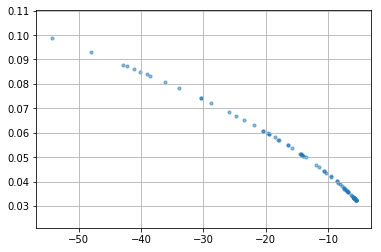

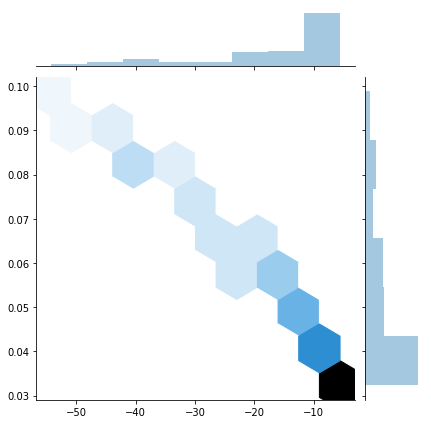

In [35]:
dz = mean_dates_4(df.reset_index().set_index('ID_CLIENTE') )
names, PV, ST = KVS_TEST(dz.loc[IX], y_train, pv0 = 1e-5)
print(len(names), dz.shape)
scatter(log10(array(PV)) , ( array(ST)) , alpha = .5, s = 10), grid()
sns.jointplot(x = log10( array(PV)+1e-300), y = ( array(ST)   ), kind="hex")

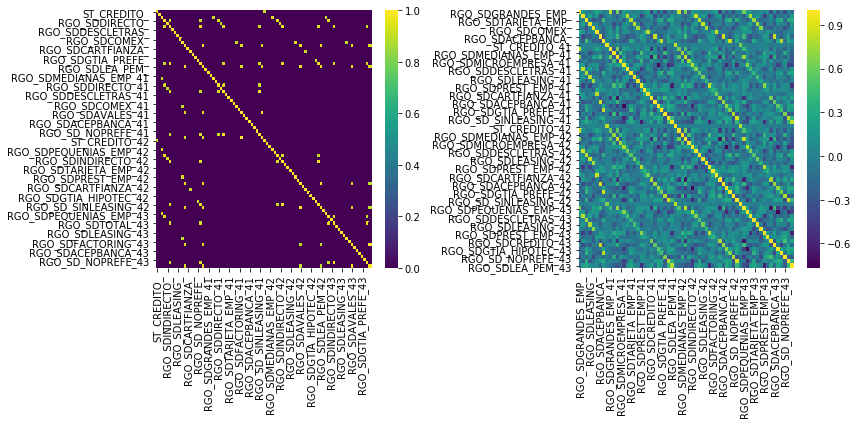

63


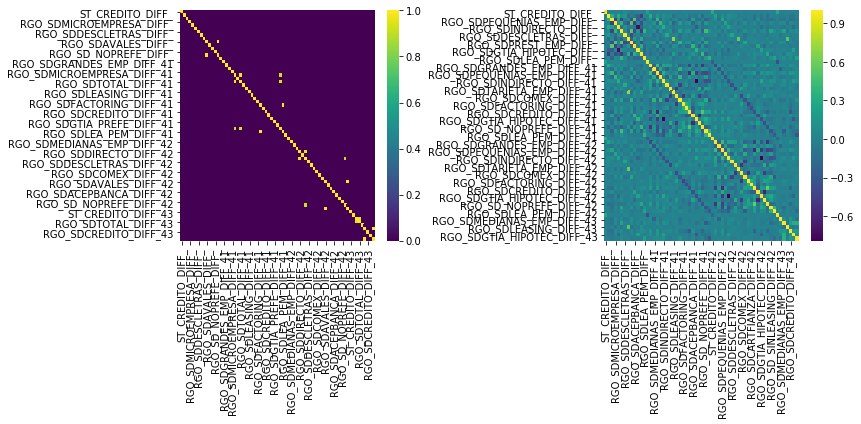

60


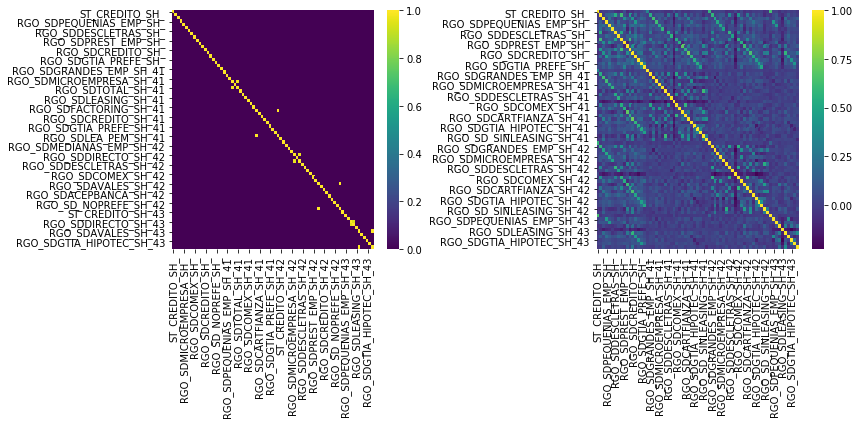

69


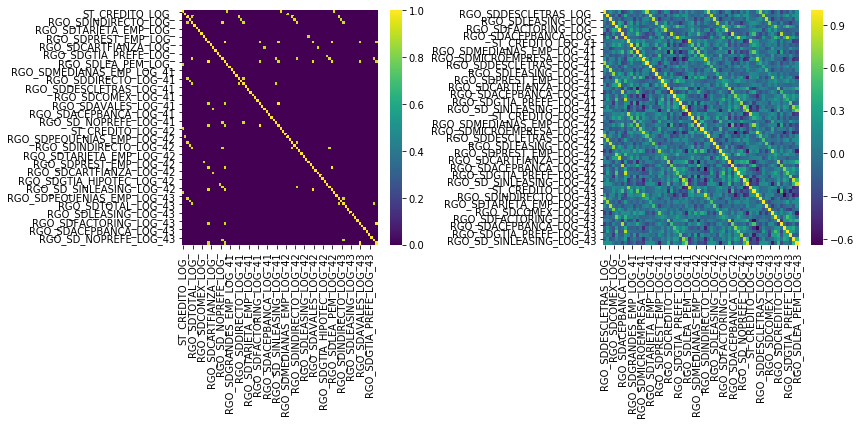

64


In [36]:
dfA = mean_test(df.reset_index().set_index('ID_CLIENTE'), IX, y_train, namecol = '_', pv0 = 1e-3 )
dfD = mean_test(dff1.reset_index().set_index('ID_CLIENTE'), IX, y_train, namecol = '_DIFF_', pv0 = 1e-3 )
dfSH = mean_test(dff_sh.reset_index().set_index('ID_CLIENTE'), IX, y_train, namecol = '_SH_', pv0 = 1e-3 )
dfLOG = mean_test( dflog.reset_index().set_index('ID_CLIENTE') , IX, y_train, namecol = '_LOG_', pv0 = 1e-3 )

del  dff1, dff_sh, dflog, dz, df


In [37]:
DF = pd.concat([dfA, dfD, dfSH, dfLOG], axis = 1)
del dfA, dfD, dfSH, dfLOG
DF.head()

,RGO_SDGRANDES_EMP_,RGO_SDDESCLETRAS_,RGO_SDTARJETA_EMP_,RGO_SDLEASING_,RGO_SDCOMEX_,RGO_SDCARTFIANZA_,RGO_SDACEPBANCA_,RGO_SDGTIA_PREFE_,ST_CREDITO_41,RGO_SDGRANDES_EMP_41,...,RGO_SDCOMEX_LOG_43,RGO_SDPREST_EMP_LOG_43,RGO_SDFACTORING_LOG_43,RGO_SDCREDITO_LOG_43,RGO_SDACEPBANCA_LOG_43,RGO_SDGTIA_HIPOTEC_LOG_43,RGO_SDGTIA_PREFE_LOG_43,RGO_SD_NOPREFE_LOG_43,RGO_SD_SINLEASING_LOG_43,RGO_SDLEA_PEM_LOG_43
ID_CLIENTE,,,,,,,,,,,,,,,,,,,,,
1,8.4375,10.500000,6.312500,6.687500,8.812500,13.4375,8.375000,8.6875,1.0,10.250000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,9.5000,12.038462,11.153846,14.576923,8.384615,13.5000,9.769231,8.5000,1.0,10.500000,...,1.398438,1.804688,2.628906,2.943359,1.646484,1.438477,2.205078,2.800781,1.793945,2.496094
3,6.5625,10.875000,8.250000,12.625000,9.000000,16.7500,3.250000,10.9375,1.0,7.875000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,15.2000,9.000000,15.050000,10.450000,14.275000,9.9750,8.350000,15.4250,1.0,16.166667,...,2.695312,2.429688,2.384766,1.522461,1.950195,2.304688,2.552734,1.763672,2.441406,2.232422
6,5.7000,8.500000,13.500000,10.700000,5.850000,12.0000,6.550000,11.9500,1.0,6.083333,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [38]:
df = df_endeudamiento.reset_index().set_index(['ID_CLIENTE','MES', 'MES_T0'])
df.drop(columns = 'CD_BANCO', inplace = True)
dfSTD =  df.groupby('ID_CLIENTE').std()
dfK = df.groupby(['ID_CLIENTE']).apply( pd.DataFrame.kurt )
dfSK = df.groupby(['ID_CLIENTE']).apply( pd.DataFrame.skew )

print(dfSTD.shape, dfK.shape, dfSK.shape)

names, pv, st = KVS_TEST(dfSTD.loc[IX], y_train,  pv0 = 1e-3 )
dfSTD = dfSTD[names]
print(len(names))

names, pv, st = KVS_TEST(dfK.loc[IX], y_train,  pv0 = 1e-3 )
dfK = dfK[names] 
print(len(names))

names, pv, st = KVS_TEST(dfSK.loc[IX], y_train,  pv0 = 1e-3)
dfSK = dfSK[names]
print(len(names))

cc = [ c + '_STD' for c in dfSTD.columns]
dfSTD.columns = cc

cc = [ c + '_KURT' for c in dfK.columns]
dfK.columns = cc

cc = [ c + '_SKEW' for c in dfSK.columns]
dfSK.columns = cc

dfST = pd.concat([dfSTD, dfK, dfSK], axis = 1)
del dfSTD, dfK, dfSK, df

dfST.head()

(70721, 23) (70721, 23) (70721, 23)
22
10
14


,ST_CREDITO_STD,RGO_SDGRANDES_EMP_STD,RGO_SDPEQUENIAS_EMP_STD,RGO_SDMICROEMPRESA_STD,RGO_SDDIRECTO_STD,RGO_SDINDIRECTO_STD,RGO_SDTOTAL_STD,RGO_SDDESCLETRAS_STD,RGO_SDTARJETA_EMP_STD,RGO_SDLEASING_STD,...,RGO_SDTARJETA_EMP_SKEW,RGO_SDLEASING_SKEW,RGO_SDCOMEX_SKEW,RGO_SDPREST_EMP_SKEW,RGO_SDAVALES_SKEW,RGO_SDCARTFIANZA_SKEW,RGO_SDCREDITO_SKEW,RGO_SDGTIA_PREFE_SKEW,RGO_SD_NOPREFE_SKEW,RGO_SDLEA_PEM_SKEW
ID_CLIENTE,,,,,,,,,,,,,,,,,,,,,
1,0.0,4.426718,6.082763,2.792848,3.859512,0.957427,3.803507,2.581989,5.325646,4.497685,...,1.232609,0.661514,1.104241,0.000000,0.895257,-0.456594,-2.409874,-0.377611,-2.526103,0.895257
2,0.0,4.649731,5.483963,4.552599,3.482042,5.138243,3.507355,4.265965,6.290897,2.759320,...,0.190636,-0.374235,0.944140,-0.440583,-0.277691,-0.155573,-1.152654,-0.100283,-1.102770,-0.277691
3,0.0,4.130678,3.054368,5.269013,1.064581,4.777988,0.957427,6.692035,7.028513,5.475704,...,0.581947,-0.341176,0.774934,0.733464,-1.178292,-2.028815,-2.922167,-1.771798,-2.971048,-1.178292
5,0.0,5.302152,2.302591,2.921077,7.753204,5.936415,7.628850,3.987159,5.320256,6.778359,...,-0.385274,-0.272879,-3.849910,-0.032731,-0.361288,1.381485,-0.177081,-1.208234,0.503959,-0.361288
6,0.0,4.092355,5.254322,6.312060,3.874342,2.921787,3.864481,8.016430,6.143032,4.725073,...,-0.853662,0.441434,1.351650,0.527928,-0.261355,-0.552110,-0.797692,-0.686457,-1.485194,-0.261355


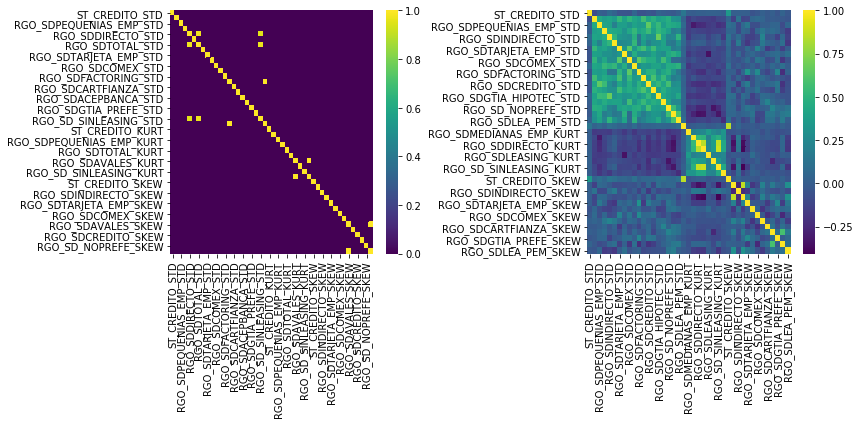

41


In [39]:
a = find_corr(dfST, cc = .95)
dfST = dfST[a]
print(len(a))

In [40]:
DF_ENDEUDAMIENTO = pd.concat([DF, dfST], axis = 1)
del dfST, DF
DF_ENDEUDAMIENTO.head()

,RGO_SDGRANDES_EMP_,RGO_SDDESCLETRAS_,RGO_SDTARJETA_EMP_,RGO_SDLEASING_,RGO_SDCOMEX_,RGO_SDCARTFIANZA_,RGO_SDACEPBANCA_,RGO_SDGTIA_PREFE_,ST_CREDITO_41,RGO_SDGRANDES_EMP_41,...,RGO_SDTOTAL_SKEW,RGO_SDTARJETA_EMP_SKEW,RGO_SDLEASING_SKEW,RGO_SDCOMEX_SKEW,RGO_SDPREST_EMP_SKEW,RGO_SDCARTFIANZA_SKEW,RGO_SDCREDITO_SKEW,RGO_SDGTIA_PREFE_SKEW,RGO_SD_NOPREFE_SKEW,RGO_SDLEA_PEM_SKEW
ID_CLIENTE,,,,,,,,,,,,,,,,,,,,,
1,8.4375,10.500000,6.312500,6.687500,8.812500,13.4375,8.375000,8.6875,1.0,10.250000,...,-0.186931,1.232609,0.661514,1.104241,0.000000,-0.456594,-2.409874,-0.377611,-2.526103,0.895257
2,9.5000,12.038462,11.153846,14.576923,8.384615,13.5000,9.769231,8.5000,1.0,10.500000,...,-0.071671,0.190636,-0.374235,0.944140,-0.440583,-0.155573,-1.152654,-0.100283,-1.102770,-0.277691
3,6.5625,10.875000,8.250000,12.625000,9.000000,16.7500,3.250000,10.9375,1.0,7.875000,...,-0.276716,0.581947,-0.341176,0.774934,0.733464,-2.028815,-2.922167,-1.771798,-2.971048,-1.178292
5,15.2000,9.000000,15.050000,10.450000,14.275000,9.9750,8.350000,15.4250,1.0,16.166667,...,-0.521043,-0.385274,-0.272879,-3.849910,-0.032731,1.381485,-0.177081,-1.208234,0.503959,-0.361288
6,5.7000,8.500000,13.500000,10.700000,5.850000,12.0000,6.550000,11.9500,1.0,6.083333,...,-0.749702,-0.853662,0.441434,1.351650,0.527928,-0.552110,-0.797692,-0.686457,-1.485194,-0.261355


In [41]:
dCD = df_endeudamiento['CD_BANCO'].apply(lambda x: 'CD_' + str(x)  )
dCD.head()

ID_CLIENTE
76119    CD_106
50080    CD_228
98183    CD_107
85467     CD_72
59930    CD_106
Name: CD_BANCO, dtype: object

In [42]:
dCD1 = df_endeudamiento['ST_CREDITO'].apply(lambda x: 'ST_CREDITO_' + str(x)  )
dCD1.head()

ID_CLIENTE
76119    ST_CREDITO_1.0
50080    ST_CREDITO_1.0
98183    ST_CREDITO_1.0
85467    ST_CREDITO_1.0
59930    ST_CREDITO_1.0
Name: ST_CREDITO, dtype: object

In [43]:
dCD = pd.concat([dCD, dCD1], axis =1)
dCD.head()

,CD_BANCO,ST_CREDITO
ID_CLIENTE,,
76119,CD_106,ST_CREDITO_1.0
50080,CD_228,ST_CREDITO_1.0
98183,CD_107,ST_CREDITO_1.0
85467,CD_72,ST_CREDITO_1.0
59930,CD_106,ST_CREDITO_1.0


In [44]:
dCD = pd.get_dummies(dCD)
print(dCD.shape)
dCD.head()

(2174946, 82)


,CD_BANCO_CD_1,CD_BANCO_CD_101,CD_BANCO_CD_102,CD_BANCO_CD_103,CD_BANCO_CD_104,CD_BANCO_CD_106,CD_BANCO_CD_107,CD_BANCO_CD_108,CD_BANCO_CD_109,CD_BANCO_CD_110,...,CD_BANCO_CD_61,CD_BANCO_CD_72,CD_BANCO_CD_73,CD_BANCO_CD_76,CD_BANCO_CD_82,ST_CREDITO_ST_CREDITO_1.0,ST_CREDITO_ST_CREDITO_4.0,ST_CREDITO_ST_CREDITO_5.0,ST_CREDITO_ST_CREDITO_6.0,ST_CREDITO_ST_CREDITO_nan
ID_CLIENTE,,,,,,,,,,,,,,,,,,,,,
76119,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
50080,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
98183,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,1,0,0,0,0
85467,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,1,0,0,0,0
59930,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0


In [45]:
dCD = dCD.groupby('ID_CLIENTE').sum()
print(dCD.shape)
dCD.head()

(70721, 82)


,CD_BANCO_CD_1,CD_BANCO_CD_101,CD_BANCO_CD_102,CD_BANCO_CD_103,CD_BANCO_CD_104,CD_BANCO_CD_106,CD_BANCO_CD_107,CD_BANCO_CD_108,CD_BANCO_CD_109,CD_BANCO_CD_110,...,CD_BANCO_CD_61,CD_BANCO_CD_72,CD_BANCO_CD_73,CD_BANCO_CD_76,CD_BANCO_CD_82,ST_CREDITO_ST_CREDITO_1.0,ST_CREDITO_ST_CREDITO_4.0,ST_CREDITO_ST_CREDITO_5.0,ST_CREDITO_ST_CREDITO_6.0,ST_CREDITO_ST_CREDITO_nan
ID_CLIENTE,,,,,,,,,,,,,,,,,,,,,
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,8,0,0,0,8
2,0,2,0,0,0,0,0,0,0,0,...,0,0,0,0,0,14,0,0,0,12
3,0,0,0,0,0,0,0,0,0,0,...,8,0,0,0,0,16,0,0,0,0
5,10,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,22,0,0,0,18
6,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,15,0,0,0,5


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log10
  This is separate from the ipykernel package so we can avoid doing imports until


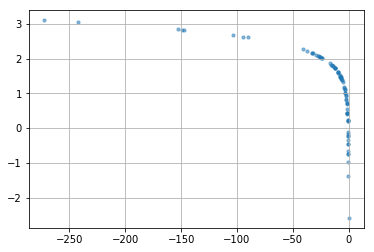

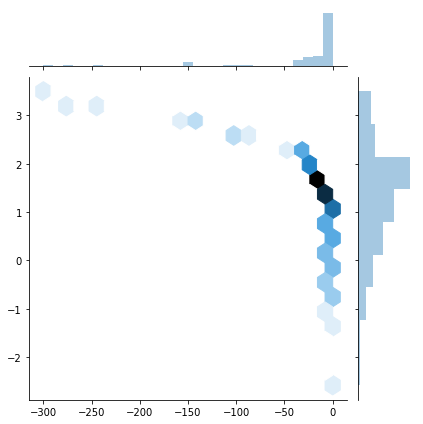

In [46]:
from sklearn.feature_selection import  chi2
a, b = chi2(dCD.loc[IX], y_train)
scatter(log10(b), log10(a), alpha = .5, s = 10), grid()
sns.jointplot(x = log10(b + 1e-300), y = log10(a + 1e-300), kind="hex")



In [47]:
COLCD = dCD.columns[a>80]
print(len(COLCD))
dCD = dCD[COLCD]
dCD.head()

22


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in greater
  """Entry point for launching an IPython kernel.


,CD_BANCO_CD_1,CD_BANCO_CD_102,CD_BANCO_CD_106,CD_BANCO_CD_109,CD_BANCO_CD_125,CD_BANCO_CD_140,CD_BANCO_CD_144,CD_BANCO_CD_156,CD_BANCO_CD_171,CD_BANCO_CD_172,...,CD_BANCO_CD_236,CD_BANCO_CD_237,CD_BANCO_CD_239,CD_BANCO_CD_248,CD_BANCO_CD_397,CD_BANCO_CD_4,CD_BANCO_CD_6,ST_CREDITO_ST_CREDITO_1.0,ST_CREDITO_ST_CREDITO_4.0,ST_CREDITO_ST_CREDITO_5.0
ID_CLIENTE,,,,,,,,,,,,,,,,,,,,,
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,8,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,24,0,0,0,0,14,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,16,0,0
5,10,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,26,22,0,0
6,0,0,0,0,0,0,0,0,0,0,...,0,10,0,0,0,0,2,15,0,0


In [48]:
DF_ENDEUDAMIENTO = pd.concat([DF_ENDEUDAMIENTO,dCD ], axis = 1)
del dCD, df_endeudamiento
print(DF_ENDEUDAMIENTO.shape)
DF_ENDEUDAMIENTO.head()

(70721, 319)


,RGO_SDGRANDES_EMP_,RGO_SDDESCLETRAS_,RGO_SDTARJETA_EMP_,RGO_SDLEASING_,RGO_SDCOMEX_,RGO_SDCARTFIANZA_,RGO_SDACEPBANCA_,RGO_SDGTIA_PREFE_,ST_CREDITO_41,RGO_SDGRANDES_EMP_41,...,CD_BANCO_CD_236,CD_BANCO_CD_237,CD_BANCO_CD_239,CD_BANCO_CD_248,CD_BANCO_CD_397,CD_BANCO_CD_4,CD_BANCO_CD_6,ST_CREDITO_ST_CREDITO_1.0,ST_CREDITO_ST_CREDITO_4.0,ST_CREDITO_ST_CREDITO_5.0
ID_CLIENTE,,,,,,,,,,,,,,,,,,,,,
1,8.4375,10.500000,6.312500,6.687500,8.812500,13.4375,8.375000,8.6875,1.0,10.250000,...,0,0,0,0,0,0,0,8,0,0
2,9.5000,12.038462,11.153846,14.576923,8.384615,13.5000,9.769231,8.5000,1.0,10.500000,...,0,0,24,0,0,0,0,14,0,0
3,6.5625,10.875000,8.250000,12.625000,9.000000,16.7500,3.250000,10.9375,1.0,7.875000,...,0,0,0,0,0,0,0,16,0,0
5,15.2000,9.000000,15.050000,10.450000,14.275000,9.9750,8.350000,15.4250,1.0,16.166667,...,0,0,0,0,0,0,26,22,0,0
6,5.7000,8.500000,13.500000,10.700000,5.850000,12.0000,6.550000,11.9500,1.0,6.083333,...,0,10,0,0,0,0,2,15,0,0


In [49]:
df = pd.concat([df_stock_train, df_stock_test], axis =0)
ID_CLIENTE = df.index
df.head()

,ID,MES_T0,FUGA_3M,FH_NACIMIENTO,FH_ALTA,RGO_RIEGO_BBVA,RGO_RIESGO_SIST,RGO_SDO_MEDIO_ACTIVO,RGO_SDO_MEDIO_PASIVO,RGO_MARGEN_OPER_MES,RGO_MARGEN_OPER_ACUM,RGO_FACTURA_ANUAL,TO_EMPLEADOS,CD_SBS_NORMAL,CD_SBS_CPP,CD_SBS_DDP,TP_VIVI,TP_PERSONA,TIPO_NEGOCIO
ID_CLIENTE,,,,,,,,,,,,,,,,,,,
48117,201808_48117,201808,0.0,2015-12-04 00:00:00,2017-09-04 00:00:00,1,8,6,9,1,1,7,2.0,100.00,0.00,0.0,LEGAL,J,Pyme
87846,201808_87846,201808,1.0,1970-11-11 00:00:00,2007-08-14 00:00:00,1,13,16,15,1,1,18,0.0,99.97,0.03,0.0,HOGAR,A,PNN
89372,201808_89372,201808,0.0,1985-01-23 00:00:00,2006-02-22 00:00:00,1,5,8,7,1,1,9,0.0,100.00,0.00,0.0,HOGAR,A,PNN
87164,201804_87164,201804,0.0,2008-01-01 00:00:00,2008-06-12 00:00:00,1,17,1,20,1,1,2,0.0,NaN,NaN,NaN,LEGAL,J,Pyme
13922,201804_13922,201804,0.0,2016-08-11 00:00:00,2017-01-04 00:00:00,1,15,15,17,1,1,17,0.0,NaN,NaN,NaN,LEGAL,J,Pyme


In [50]:
fh_n = df.FH_NACIMIENTO
fh_a = df.FH_ALTA
fh_n = pd.to_datetime(fh_n, format='%Y-%m-%d', errors='ignore').dt.year + (pd.to_datetime(fh_n, format='%Y-%m-%d', errors='ignore').dt.month - 1)/12
fh_a = pd.to_datetime(fh_a, format='%Y-%m-%d', errors='ignore').dt.year + (pd.to_datetime(fh_a, format='%Y-%m-%d', errors='ignore').dt.month - 1)/12

fh_n.fillna(value = fh_n.median(),inplace=True)
fh_a.fillna(value=fh_a.median(), inplace=True)
df.FH_NACIMIENTO = 2020-fh_n
df.FH_ALTA = 2020-fh_a
df.info()
df.head()



<class 'pandas.core.frame.DataFrame'>
Int64Index: 99999 entries, 48117 to 11256
Data columns (total 19 columns):
ID                      99999 non-null object
MES_T0                  99999 non-null int64
FUGA_3M                 73661 non-null float64
FH_NACIMIENTO           99999 non-null float64
FH_ALTA                 99999 non-null float64
RGO_RIEGO_BBVA          99999 non-null int64
RGO_RIESGO_SIST         99999 non-null int64
RGO_SDO_MEDIO_ACTIVO    99999 non-null int64
RGO_SDO_MEDIO_PASIVO    99999 non-null int64
RGO_MARGEN_OPER_MES     99999 non-null int64
RGO_MARGEN_OPER_ACUM    99999 non-null int64
RGO_FACTURA_ANUAL       99999 non-null int64
TO_EMPLEADOS            98107 non-null float64
CD_SBS_NORMAL           69722 non-null float64
CD_SBS_CPP              69722 non-null float64
CD_SBS_DDP              69722 non-null float64
TP_VIVI                 98828 non-null object
TP_PERSONA              99999 non-null object
TIPO_NEGOCIO            99999 non-null object
dtypes: float6

,ID,MES_T0,FUGA_3M,FH_NACIMIENTO,FH_ALTA,RGO_RIEGO_BBVA,RGO_RIESGO_SIST,RGO_SDO_MEDIO_ACTIVO,RGO_SDO_MEDIO_PASIVO,RGO_MARGEN_OPER_MES,RGO_MARGEN_OPER_ACUM,RGO_FACTURA_ANUAL,TO_EMPLEADOS,CD_SBS_NORMAL,CD_SBS_CPP,CD_SBS_DDP,TP_VIVI,TP_PERSONA,TIPO_NEGOCIO
ID_CLIENTE,,,,,,,,,,,,,,,,,,,
48117,201808_48117,201808,0.0,4.083333,2.333333,1,8,6,9,1,1,7,2.0,100.00,0.00,0.0,LEGAL,J,Pyme
87846,201808_87846,201808,1.0,49.166667,12.416667,1,13,16,15,1,1,18,0.0,99.97,0.03,0.0,HOGAR,A,PNN
89372,201808_89372,201808,0.0,35.000000,13.916667,1,5,8,7,1,1,9,0.0,100.00,0.00,0.0,HOGAR,A,PNN
87164,201804_87164,201804,0.0,12.000000,11.583333,1,17,1,20,1,1,2,0.0,NaN,NaN,NaN,LEGAL,J,Pyme
13922,201804_13922,201804,0.0,3.416667,3.000000,1,15,15,17,1,1,17,0.0,NaN,NaN,NaN,LEGAL,J,Pyme


In [51]:
COLD = df.dtypes[df.dtypes == 'object'].index
COLD

Index(['ID', 'TP_VIVI', 'TP_PERSONA', 'TIPO_NEGOCIO'], dtype='object')

In [52]:
[ print(df[c].unique(), size(df[c].unique() ) ) for c in COLD ]

['201808_48117' '201808_87846' '201808_89372' ... '201901_12908'
 '201901_10853' '201901_11256'] 99999
['LEGAL' 'HOGAR' nan 'TRABAJO'] 4
['J' 'A' 'F'] 3
['Pyme' 'PNN'] 2


[None, None, None, None]

In [53]:
COL_N = [ c for c in df.columns if c not in COLD]
#COL_N.remove( 'ID_CLIENTE')
COL_N

['MES_T0',
 'FUGA_3M',
 'FH_NACIMIENTO',
 'FH_ALTA',
 'RGO_RIEGO_BBVA',
 'RGO_RIESGO_SIST',
 'RGO_SDO_MEDIO_ACTIVO',
 'RGO_SDO_MEDIO_PASIVO',
 'RGO_MARGEN_OPER_MES',
 'RGO_MARGEN_OPER_ACUM',
 'RGO_FACTURA_ANUAL',
 'TO_EMPLEADOS',
 'CD_SBS_NORMAL',
 'CD_SBS_CPP',
 'CD_SBS_DDP']

In [54]:
IX = intersect1d(df_stock_train.index , df.index)
y_train = df_stock_train.loc[IX].FUGA_3M
print(y_train.shape)


(73661,)


In [55]:
for c in COLD[1:]:
    df[c].fillna(-999, inplace = True)
df[COLD[1:]].head()

,TP_VIVI,TP_PERSONA,TIPO_NEGOCIO
ID_CLIENTE,,,
48117,LEGAL,J,Pyme
87846,HOGAR,A,PNN
89372,HOGAR,A,PNN
87164,LEGAL,J,Pyme
13922,LEGAL,J,Pyme


In [56]:
# Label Encoding
from sklearn.preprocessing import LabelEncoder
for f in COLD[1:]: 
    lbl = LabelEncoder()
    lbl.fit(list(df[f].values) )
    df[f] = lbl.transform(list(df[f].values))
df[COLD[1:]].head()

,TP_VIVI,TP_PERSONA,TIPO_NEGOCIO
ID_CLIENTE,,,
48117,2,2,1
87846,1,0,0
89372,1,0,0
87164,2,2,1
13922,2,2,1


In [57]:
df.columns

Index(['ID', 'MES_T0', 'FUGA_3M', 'FH_NACIMIENTO', 'FH_ALTA', 'RGO_RIEGO_BBVA',
       'RGO_RIESGO_SIST', 'RGO_SDO_MEDIO_ACTIVO', 'RGO_SDO_MEDIO_PASIVO',
       'RGO_MARGEN_OPER_MES', 'RGO_MARGEN_OPER_ACUM', 'RGO_FACTURA_ANUAL',
       'TO_EMPLEADOS', 'CD_SBS_NORMAL', 'CD_SBS_CPP', 'CD_SBS_DDP', 'TP_VIVI',
       'TP_PERSONA', 'TIPO_NEGOCIO'],
      dtype='object')

In [58]:
DF_STOCK  = df[COL_N + COLD[1:].tolist()]
DF_STOCK.head()

,MES_T0,FUGA_3M,FH_NACIMIENTO,FH_ALTA,RGO_RIEGO_BBVA,RGO_RIESGO_SIST,RGO_SDO_MEDIO_ACTIVO,RGO_SDO_MEDIO_PASIVO,RGO_MARGEN_OPER_MES,RGO_MARGEN_OPER_ACUM,RGO_FACTURA_ANUAL,TO_EMPLEADOS,CD_SBS_NORMAL,CD_SBS_CPP,CD_SBS_DDP,TP_VIVI,TP_PERSONA,TIPO_NEGOCIO
ID_CLIENTE,,,,,,,,,,,,,,,,,,
48117,201808,0.0,4.083333,2.333333,1,8,6,9,1,1,7,2.0,100.00,0.00,0.0,2,2,1
87846,201808,1.0,49.166667,12.416667,1,13,16,15,1,1,18,0.0,99.97,0.03,0.0,1,0,0
89372,201808,0.0,35.000000,13.916667,1,5,8,7,1,1,9,0.0,100.00,0.00,0.0,1,0,0
87164,201804,0.0,12.000000,11.583333,1,17,1,20,1,1,2,0.0,NaN,NaN,NaN,2,2,1
13922,201804,0.0,3.416667,3.000000,1,15,15,17,1,1,17,0.0,NaN,NaN,NaN,2,2,1


In [59]:
XF = pd.concat([DF_STOCK, DF_ENDEUDAMIENTO, DF_PRODUCTO], axis =  1)
del DF_STOCK, DF_ENDEUDAMIENTO, DF_PRODUCTO
XF.head()

,MES_T0,FUGA_3M,FH_NACIMIENTO,FH_ALTA,RGO_RIEGO_BBVA,RGO_RIESGO_SIST,RGO_SDO_MEDIO_ACTIVO,RGO_SDO_MEDIO_PASIVO,RGO_MARGEN_OPER_MES,RGO_MARGEN_OPER_ACUM,...,RGO_MARGEN_CARTERA_SKEW,RGO_MARGEN_STANDBY_SKEW,RGO_PASIVO_SKEW,RGO_ACTIVO_SKEW,NU_CTA_TDC_PNATURAL_0,NU_CTA_TDC_PJURIDICA_1,NU_CTA_DOMI_1,NU_CTA_NOMINA_0,NU_CTA_NOMINA_1,NU_CTA_VALORES_1
ID_CLIENTE,,,,,,,,,,,,,,,,,,,,,
1,201806,0.0,24.500000,3.333333,5,8,14,10,5,1,...,0.000000,0.000000,0.000000,0.000000,11.0,0.0,0.0,11.0,0.0,0.0
2,201808,0.0,51.833333,12.250000,3,5,12,7,4,3,...,-0.875713,2.178717,2.178717,-0.383807,13.0,0.0,0.0,13.0,0.0,0.0
3,201803,0.0,62.583333,20.250000,5,7,14,9,5,5,...,-0.676243,-0.898676,-0.040409,0.414976,8.0,0.0,0.0,8.0,0.0,0.0
4,201803,0.0,43.500000,2.166667,10,14,2,16,11,8,...,-1.414214,-1.658524,-1.494105,1.846278,4.0,0.0,0.0,4.0,0.0,0.0
5,201808,0.0,8.583333,6.000000,20,20,20,15,18,19,...,-0.946212,-0.848679,-0.018540,0.000000,13.0,13.0,0.0,13.0,0.0,0.0


# TRANSAC CANALES DATASET

In [60]:
df_transac = pd.read_csv('/kaggle/input/attrition-persona-juridica-bbva/DATA_TRANSAC_CANALES_F.txt', index_col = 'ID_CLIENTE')
CNA  = [c for c in df_transac.columns if c.count('CT_')==1]
CNUM  = [c for c in df_transac.columns if c not in CNA]
print(df_transac.shape, len(CNA), len(CNUM) )
print(CNA)
print(CNUM)
df_transac['CTA'] = df_transac[CNA].mean(axis = 1) 
df_transac = df_transac[ list(CNUM) + ['CTA']]
df_transac.rename({'PERIODO': 'MES'}, axis=1, inplace=True)

print(df_transac.shape)
df_transac = pd.concat([df_transac, MES_T0.loc[df_transac.index] ], axis = 1)
# works with months minor a month to evaluate
df_transac = df_transac[df_transac.MES<df_transac.MES_T0]
print(df_transac.shape)
df_transac.head()

(77009, 13) 6 7
['CT_RECAUDO', 'CT_TRANSF_INTE', 'CT_CHEQUE_REC', 'CT_TRANSFE_LOCALES', 'CT_PAGO_PROVEE', 'CT_SUNAT_PYME']
['PERIODO', 'RGO_MTO_RECAUDO', 'RGO_MTO_TRANSF_INTE', 'RGO_MTO_CHEQUE_REC', 'RGO_MTO_TRANSFE_LOCALES', 'RGO_MTO_PAGO_PROVEE', 'RGO_MTO_SUNAT_PYME']
(77009, 8)
(34143, 9)


,MES,RGO_MTO_RECAUDO,RGO_MTO_TRANSF_INTE,RGO_MTO_CHEQUE_REC,RGO_MTO_TRANSFE_LOCALES,RGO_MTO_PAGO_PROVEE,RGO_MTO_SUNAT_PYME,CTA,MES_T0
ID_CLIENTE,,,,,,,,,
60967,201809,7,11,13,20,3,1,561.0,201901
26826,201809,18,8,9,20,3,1,1683.0,201810
43613,201804,19,3,2,1,3,1,2.0,201809
57524,201808,13,18,14,1,3,1,9537.0,201902
77081,201809,18,3,18,1,3,1,4488.0,201902


In [61]:
df_transac.MES = MES_to_X(df_transac.MES)
df_transac.MES_T0 = MES_to_X(df_transac.MES_T0)
IX1 = intersect1d(IX , df_transac.index)
y_train1 =y_train.loc[IX1]
print(len(IX1), len(y_train1))

4709 4709


Mem. usage decreased to  0.72 Mb (64.6% reduction)
Mem. usage decreased to  0.72 Mb (64.6% reduction)
Mem. usage decreased to  0.65 Mb (67.8% reduction)


/opt/conda/lib/python3.6/site-packages/pandas/core/frame.py:4102: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:39: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike


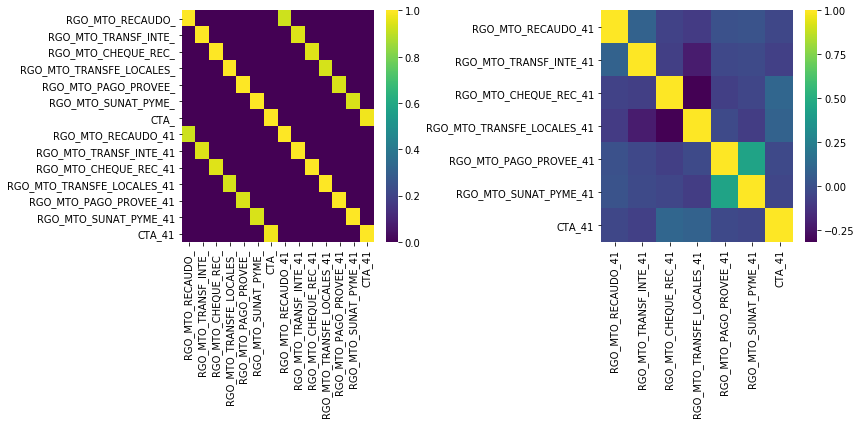

7


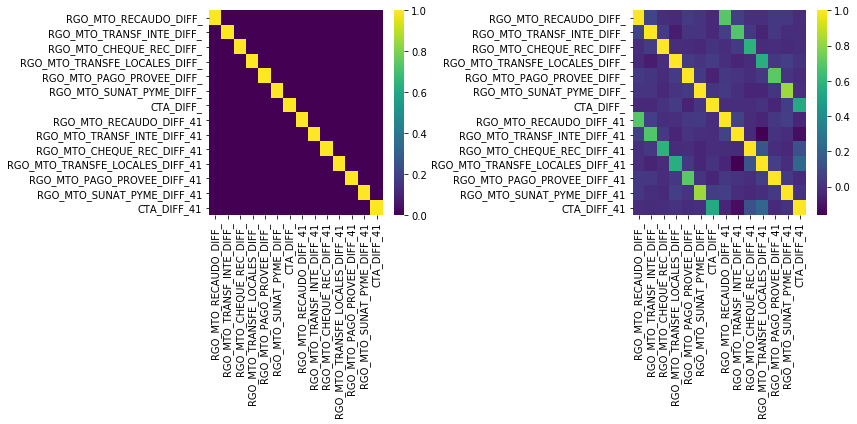

14


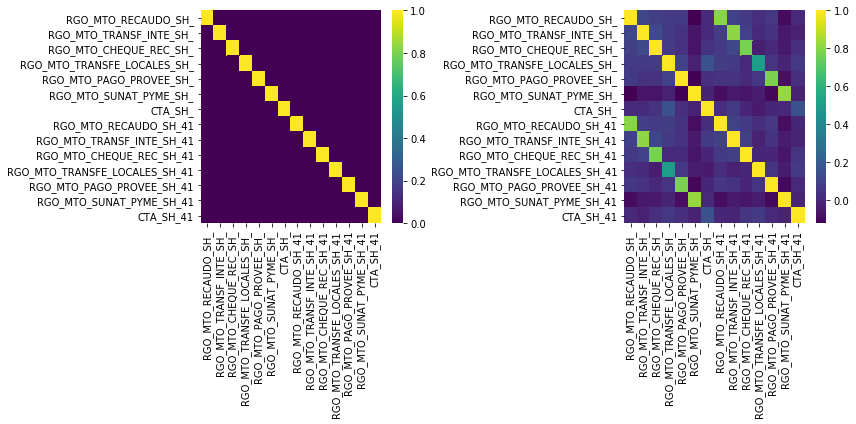

14


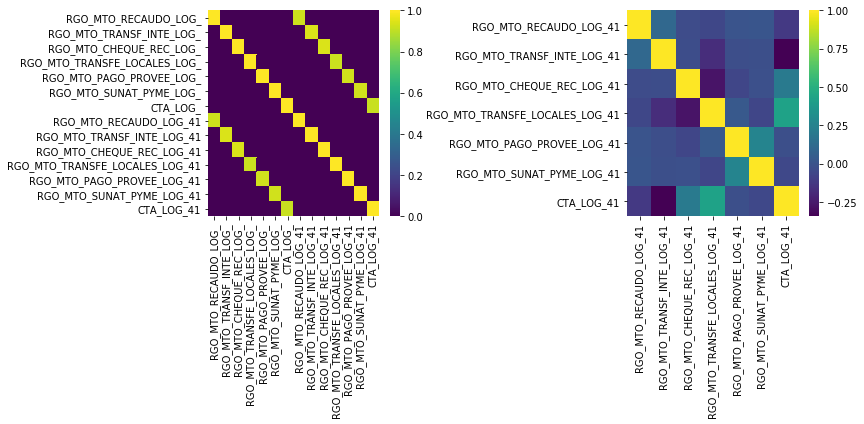

7


,RGO_MTO_RECAUDO_41,RGO_MTO_TRANSF_INTE_41,RGO_MTO_CHEQUE_REC_41,RGO_MTO_TRANSFE_LOCALES_41,RGO_MTO_PAGO_PROVEE_41,RGO_MTO_SUNAT_PYME_41,CTA_41,RGO_MTO_RECAUDO_DIFF_,RGO_MTO_TRANSF_INTE_DIFF_,RGO_MTO_CHEQUE_REC_DIFF_,...,RGO_MTO_PAGO_PROVEE_SH_41,RGO_MTO_SUNAT_PYME_SH_41,CTA_SH_41,RGO_MTO_RECAUDO_LOG_41,RGO_MTO_TRANSF_INTE_LOG_41,RGO_MTO_CHEQUE_REC_LOG_41,RGO_MTO_TRANSFE_LOCALES_LOG_41,RGO_MTO_PAGO_PROVEE_LOG_41,RGO_MTO_SUNAT_PYME_LOG_41,CTA_LOG_41
ID_CLIENTE,,,,,,,,,,,,,,,,,,,,,
16,10.333333,10.333333,2.666667,16.0,10.666667,8.333333,561.000000,-3.000000,-1.333008,1.000000,...,1.416992,2.755859,1.000000,2.158203,2.212891,0.767578,2.769531,2.214844,1.853516,6.328125
58,13.000000,6.000000,20.000000,5.0,16.000000,8.000000,1632.000000,0.000000,0.000000,0.000000,...,1.000000,1.000000,1.000000,2.564453,1.791992,2.996094,1.609375,2.773438,2.080078,7.398438
60,9.500000,8.000000,9.000000,12.0,6.000000,6.750000,7082.625000,1.000000,1.750000,2.250000,...,3.111328,0.672852,1.129317,1.785156,1.818359,1.994141,2.476562,1.190430,1.638672,8.820312
76,6.000000,18.500000,15.000000,12.5,5.750000,4.750000,7901.333333,-0.285645,0.071411,-0.142822,...,0.926758,0.991699,0.494926,1.348633,2.917969,2.708984,2.519531,1.661133,1.527344,8.968750
95,11.666667,7.333333,9.000000,9.0,9.333333,11.000000,544.000000,1.666992,-2.666016,-0.333252,...,0.894531,0.888184,0.833333,2.402344,1.708008,2.169922,2.193359,2.158203,2.386719,6.242188


In [62]:
dz = df_transac.reset_index().set_index(['ID_CLIENTE','MES', 'MES_T0'])

df = dz.copy()
dff1 = reduce_mem_usage( (df -df.groupby(['ID_CLIENTE']).shift(1)) )
dff_sh = reduce_mem_usage( (df.groupby(['ID_CLIENTE']).shift(1)/df ) )
dflog = reduce_mem_usage( df.apply(np.log) )


dff_sh.replace([np.inf, -np.inf], np.nan, inplace = True)
dff_sh.fillna(1, inplace = True)
dff1.fillna(0, inplace = True)
dflog.replace([np.inf, -np.inf], np.nan, inplace = True)
dflog.fillna(1, inplace = True)

dfA = mean_test(df.reset_index().set_index('ID_CLIENTE'), IX, y_train, namecol = '_', pv0 = 1e-10 )
dfD = mean_test(dff1.reset_index().set_index('ID_CLIENTE'), IX, y_train, namecol = '_DIFF_', pv0 = 1e-10 )
dfSH = mean_test(dff_sh.reset_index().set_index('ID_CLIENTE'), IX, y_train, namecol = '_SH_', pv0 = 1e-10 )
dfLOG = mean_test( dflog.reset_index().set_index('ID_CLIENTE') , IX, y_train, namecol = '_LOG_', pv0 = 1e-10 )

del  dff1, dff_sh, dflog, dz, df

DF = pd.concat([dfA, dfD, dfSH, dfLOG], axis = 1)
del dfA, dfD, dfSH, dfLOG
DF.head()

(8309, 7) (8309, 7) (8309, 7)
7
0
0


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:8: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
  
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:12: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
  if sys.path[0] == '':
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:16: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stabl

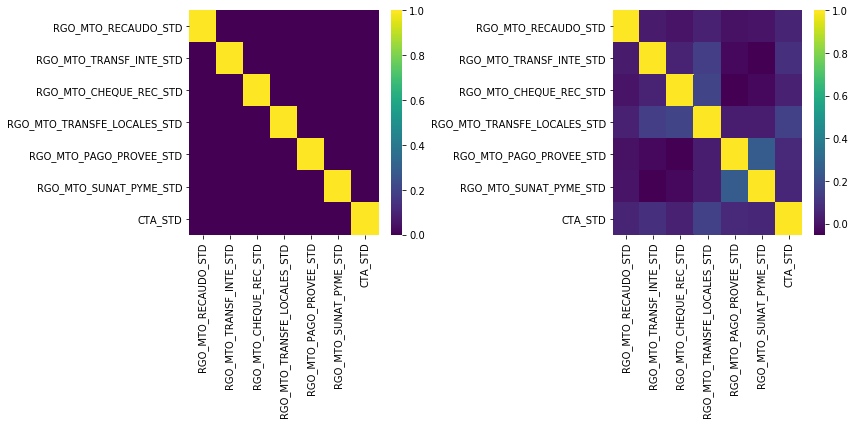

7


,RGO_MTO_RECAUDO_STD,RGO_MTO_TRANSF_INTE_STD,RGO_MTO_CHEQUE_REC_STD,RGO_MTO_TRANSFE_LOCALES_STD,RGO_MTO_PAGO_PROVEE_STD,RGO_MTO_SUNAT_PYME_STD,CTA_STD
ID_CLIENTE,,,,,,,
16,7.094599,6.110101,2.081666,1.732051,6.110101,5.686241,0.000000
58,NaN,NaN,NaN,NaN,NaN,NaN,NaN
60,7.852813,6.055301,6.480741,1.825742,6.000000,5.188127,2605.028131
76,5.678666,0.770329,5.180267,4.380275,3.650230,4.462912,3714.674253
95,4.509250,6.110101,2.645751,1.000000,4.041452,2.000000,235.558910


In [63]:
df = df_transac.reset_index().set_index(['ID_CLIENTE','MES', 'MES_T0'])
dfSTD =  df.groupby('ID_CLIENTE').std()
dfK = df.groupby(['ID_CLIENTE']).apply( pd.DataFrame.kurt )
dfSK = df.groupby(['ID_CLIENTE']).apply( pd.DataFrame.skew )

print(dfSTD.shape, dfK.shape, dfSK.shape)

names, pv , st = KVS_TEST(dfSTD.loc[IX], y_train,  pv0 = 1e-10 )
dfSTD = dfSTD[names]
print(len(names))

names, pv, st = KVS_TEST(dfK.loc[IX], y_train,  pv0 = 1e-10 )
dfK = dfK[names] 
print(len(names))

names, pv, st = KVS_TEST(dfSK.loc[IX], y_train,  pv0 = 1e-10 )
dfSK = dfSK[names]
print(len(names))

cc = [ c + '_STD' for c in dfSTD.columns]
dfSTD.columns = cc

cc = [ c + '_KURT' for c in dfK.columns]
dfK.columns = cc

cc = [ c + '_SKEW' for c in dfSK.columns]
dfSK.columns = cc

dfST = pd.concat([dfSTD, dfK, dfSK], axis = 1)
del dfSTD, dfK, dfSK, df

a = find_corr(dfST, cc = .95)
dfST = dfST[a]
print(len(a))

dfST.head()

In [64]:
DF_TRANSAC = pd.concat([DF, dfST], axis = 1)
del dfST, DF
DF_TRANSAC.head()

,RGO_MTO_RECAUDO_41,RGO_MTO_TRANSF_INTE_41,RGO_MTO_CHEQUE_REC_41,RGO_MTO_TRANSFE_LOCALES_41,RGO_MTO_PAGO_PROVEE_41,RGO_MTO_SUNAT_PYME_41,CTA_41,RGO_MTO_RECAUDO_DIFF_,RGO_MTO_TRANSF_INTE_DIFF_,RGO_MTO_CHEQUE_REC_DIFF_,...,RGO_MTO_PAGO_PROVEE_LOG_41,RGO_MTO_SUNAT_PYME_LOG_41,CTA_LOG_41,RGO_MTO_RECAUDO_STD,RGO_MTO_TRANSF_INTE_STD,RGO_MTO_CHEQUE_REC_STD,RGO_MTO_TRANSFE_LOCALES_STD,RGO_MTO_PAGO_PROVEE_STD,RGO_MTO_SUNAT_PYME_STD,CTA_STD
ID_CLIENTE,,,,,,,,,,,,,,,,,,,,,
16,10.333333,10.333333,2.666667,16.0,10.666667,8.333333,561.000000,-3.000000,-1.333008,1.000000,...,2.214844,1.853516,6.328125,7.094599,6.110101,2.081666,1.732051,6.110101,5.686241,0.000000
58,13.000000,6.000000,20.000000,5.0,16.000000,8.000000,1632.000000,0.000000,0.000000,0.000000,...,2.773438,2.080078,7.398438,NaN,NaN,NaN,NaN,NaN,NaN,NaN
60,9.500000,8.000000,9.000000,12.0,6.000000,6.750000,7082.625000,1.000000,1.750000,2.250000,...,1.190430,1.638672,8.820312,7.852813,6.055301,6.480741,1.825742,6.000000,5.188127,2605.028131
76,6.000000,18.500000,15.000000,12.5,5.750000,4.750000,7901.333333,-0.285645,0.071411,-0.142822,...,1.661133,1.527344,8.968750,5.678666,0.770329,5.180267,4.380275,3.650230,4.462912,3714.674253
95,11.666667,7.333333,9.000000,9.0,9.333333,11.000000,544.000000,1.666992,-2.666016,-0.333252,...,2.158203,2.386719,6.242188,4.509250,6.110101,2.645751,1.000000,4.041452,2.000000,235.558910


In [65]:
XF = pd.concat([XF , DF_TRANSAC ], axis = 1)

XF.drop(columns = 'FUGA_3M', inplace = True)
XF.fillna(-999, inplace = True)

X_train = XF.loc[IX].copy()
X_test = XF.loc[df_stock_test.index].copy()
print(X_train.shape, X_test.shape, XF.shape)
del XF

(73661, 1124) (26338, 1124) (99999, 1124)


# THE BEST 80 FEATURES

In [66]:
COLF_FEATURES = ['RGO_RIESGO_SIST', 'RGO_SDO_MEDIO_PASIVO', 'TP_VIVI', 'TP_PERSONA', 'RGO_PASIVO_LOG_41', 'RGO_SDO_VALORES_STD', 'NU_CTA_NOMINA_1', 'ST_CREDITO_42', 'RGO_SDPREST_EMP_41', 'RGO_PASIVO_42', 'RGO_SDINDIRECTO_LOG_41', 'ST_CREDITO_LOG_42', 'CD_BANCO_CD_6', 'RGO_SEGU_NO_VINC_42', 'RGO_SEGU_NO_VINC_LOG_42', 'RGO_PASIVO_LOG_42', 'RGO_RIEGO_BBVA', 'NU_CTA_NOMINA_0', 'RGO_SDPREST_EMP_42', 'RGO_MARGEN_OPER_MES', 'RGO_PASIVO_41', 'RGO_SDPREST_EMP_LOG_43', 'NU_CTA_TDC_PNATURAL_0', 'CD_SBS_CPP', 'ST_CREDITO_43', 'RGO_SDLEA_PEM_41', 'MES_T0', 'ST_CREDITO_LOG_43', 'RGO_SEGU_NO_VINC_STD', 'NU_CTA_TDD_STD', 'NU_CTA_CTS_SH_', 'RGO_SEGU_NO_VINC_41', 'CD_BANCO_CD_237', 'FH_ALTA', 'CD_SBS_DDP', 'RGO_SEGU_NO_VINC_LOG_41', 'NU_CTA_TDD_LOG_43', 'NU_CTA_TDD_KURT', 'RGO_SDPREST_EMP_43', 'NU_CTA_CTS_STD', 'RGO_MARGEN_AHORRO_LOG_41', 'RGO_SEGU_VINC_LOG_42', 'NU_CTA_TDD_SKEW', 'CD_SBS_NORMAL', 'RGO_MARGEN_COBRANZA_LIB_41', 'RGO_SDLEA_PEM_LOG_41', 'NU_CTA_TDD_SH_41', 'ST_CREDITO_SH_43', 'NU_CTA_TDD_SH_', 'RGO_MARGEN_COBRANZA_LIB_LOG_41', 'RGO_SDPREST_EMP_LOG_42', 'RGO_SDINDIRECTO_42', 'RGO_SDO_MEDIO_ACTIVO', 'RGO_SDINDIRECTO_LOG_43', 'RGO_SEGU_VINC_41', 'RGO_MARGEN_COBRANZA_LIB_LOG_42', 'RGO_SDLEA_PEM_SH_42', 'RGO_SDMICROEMPRESA_41', 'RGO_MARGEN_COBRANZA_LIB_42', 'RGO_SDINDIRECTO_41', 'RGO_SD_SINLEASING_41', 'RGO_SEGU_VINC_LOG_41', 'RGO_SDMICROEMPRESA_42', 'RGO_MARGEN_OPER_ACUM', 'NU_CTA_TDD_SH_43', 'RGO_MARGEN_PREST_VEHIC_41', 'RGO_SDO_VALORES_LOG_41', 'RGO_SDLEA_PEM_LOG_43', 'FH_NACIMIENTO', 'RGO_PASIVO_STD', 'RGO_SDINDIRECTO_43', 'RGO_SDPREST_EMP_DIFF_42', 'RGO_MARGEN_CTS_LOG_41', 'RGO_SDGTIA_HIPOTEC_LOG_41', 'RGO_SDLEA_PEM_SH_41', 'RGO_SDO_VALORES_41', 'RGO_MARGEN_CTE_LOG_41', 'RGO_SDLEA_PEM_LOG_42', 'RGO_SDLEA_PEM_SH_43', 'NU_CTA_AHORRO_SKEW']

In [67]:
X_train = X_train[COLF_FEATURES]
X_test = X_test[COLF_FEATURES]

In [68]:
%%time


NFOLDS = 15
folds = StratifiedKFold(n_splits=NFOLDS)

columns =  X_train.columns #COL #COLF[0:150] #  # COLF[0:85] # X_train.columns
splits = folds.split(X_train, y_train)
y_preds = np.zeros(X_test.shape[0])
y_oof = np.zeros(X_train.shape[0])
score = 0

feature_importances = pd.DataFrame()
feature_importances['feature'] = columns

model = XGBClassifier(base_score=0.3286505054538241, booster='gbtree',
       colsample_bylevel=1, colsample_bytree=1, gamma=0,
       learning_rate=0.15625549474872114, max_delta_step=0, max_depth= 9,
       min_child_weight=1, missing=None, n_estimators=100, n_jobs=-1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1, tree_method='gpu_hist', predictor='gpu_predictor' )

for fold_n, (train_index, valid_index) in enumerate(splits):
    X_train1, X_valid = X_train[columns].iloc[train_index], X_train[columns].iloc[valid_index]
    y_train1, y_valid = y_train.iloc[train_index], y_train.iloc[valid_index]
    print(y_train1.sum(), y_valid.sum(), X_train1.shape, X_valid.shape)
    
    model.fit(X_train1, y_train1,
        eval_set=[(X_train1, y_train1), (X_valid, y_valid)],
        eval_metric='auc',
        verbose=10,
        early_stopping_rounds=20)
    
    feature_importances[f'fold_{fold_n + 1}'] = model.feature_importances_
    
    y_pred_valid = model.predict_proba(X_valid)[:,1]
    y_oof[valid_index] = y_pred_valid
    print(f"Fold {fold_n + 1} | AUC: {roc_auc_score(y_valid, y_pred_valid)}")
    
    score += roc_auc_score(y_valid, y_pred_valid) / NFOLDS
    y_preds += model.predict_proba(X_test[columns])[:,1] / NFOLDS
    
    del X_train1, X_valid, y_train1, y_valid
    gc.collect()
    
print(f"\nMean AUC = {score}")
print(f"Out of folds AUC = {roc_auc_score(y_train, y_oof)}")
gc.collect()

9193 657 (68749, 80) (4912, 80)
[0]	validation_0-auc:0.850454	validation_1-auc:0.817368
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 20 rounds.
[10]	validation_0-auc:0.9084	validation_1-auc:0.837512
[20]	validation_0-auc:0.935788	validation_1-auc:0.838337
[30]	validation_0-auc:0.953688	validation_1-auc:0.840917
[40]	validation_0-auc:0.966312	validation_1-auc:0.842092
[50]	validation_0-auc:0.973209	validation_1-auc:0.842888
[60]	validation_0-auc:0.979159	validation_1-auc:0.842659
[70]	validation_0-auc:0.983639	validation_1-auc:0.841283
Stopping. Best iteration:
[55]	validation_0-auc:0.976498	validation_1-auc:0.843344

Fold 1 | AUC: 0.8433442972454289
9193 657 (68750, 80) (4911, 80)
[0]	validation_0-auc:0.850265	validation_1-auc:0.812162
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 20 roun

Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 20 rounds.
[10]	validation_0-auc:0.909686	validation_1-auc:0.83272
[20]	validation_0-auc:0.937109	validation_1-auc:0.837997
[30]	validation_0-auc:0.9551	validation_1-auc:0.837436
[40]	validation_0-auc:0.9655	validation_1-auc:0.837502
[50]	validation_0-auc:0.97215	validation_1-auc:0.837702
Stopping. Best iteration:
[36]	validation_0-auc:0.961854	validation_1-auc:0.838908

Fold 13 | AUC: 0.8389080721731054
9194 656 (68751, 80) (4910, 80)
[0]	validation_0-auc:0.853954	validation_1-auc:0.811856
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 20 rounds.
[10]	validation_0-auc:0.908416	validation_1-auc:0.837506
[20]	validation_0-auc:0.935202	validation_1-auc:0.842649
[30]	validation_0-auc:0.954317	validation_1-auc:0.844867
[40]	validation_0-auc:0.964666

0

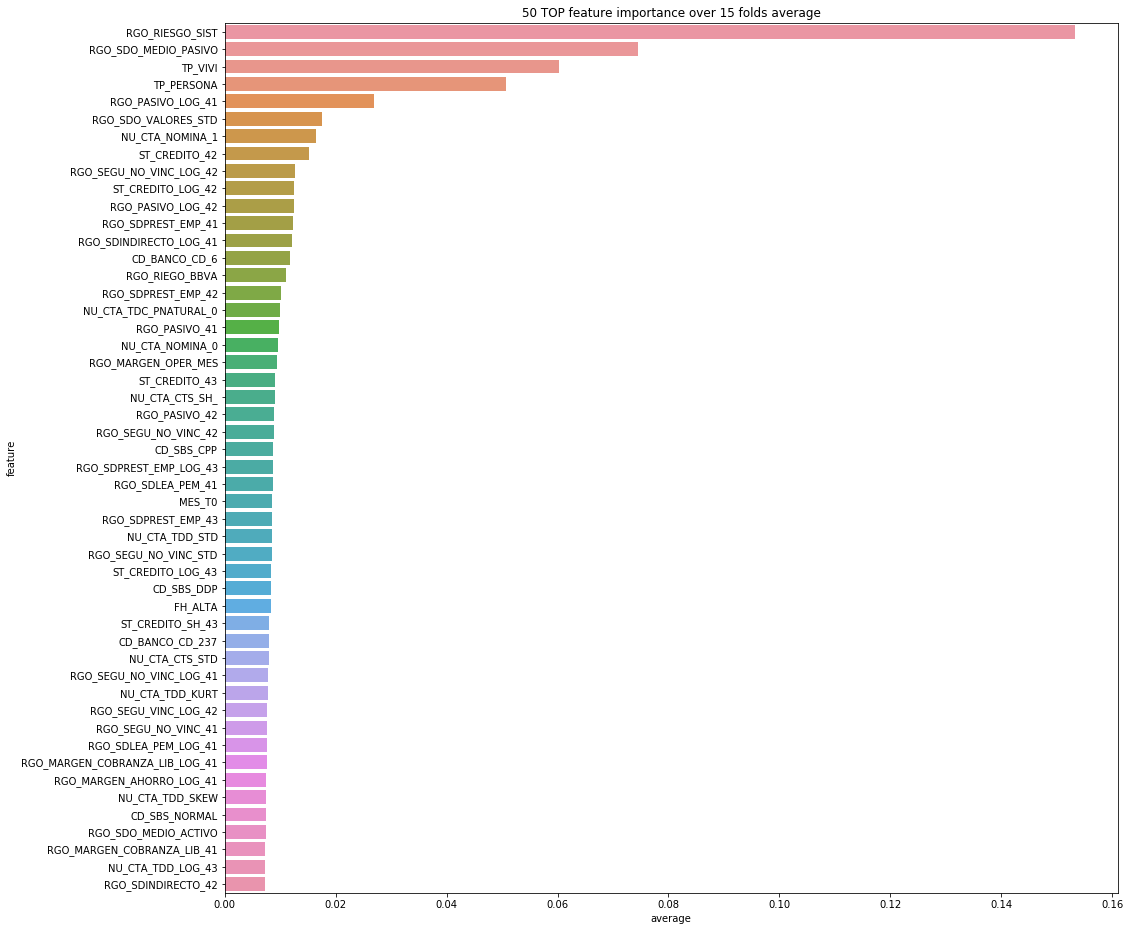

In [75]:
plt.figure(figsize=(16, 16))
feature_importances['average'] = feature_importances[[f'fold_{fold_n + 1}' for fold_n in range(folds.n_splits)]].mean(axis=1)
sns.barplot(data=feature_importances.sort_values(by='average', ascending=False).head(50), x='average', y='feature');
plt.title('50 TOP feature importance over {} folds average'.format(15));



In [69]:

df_stock_submit = pd.read_csv('/kaggle/input/attrition-persona-juridica-bbva/DATA_STOCK_SUBMIT_SAMPLE.csv')
df_stock_submit.FUGA_3M = y_preds
df_stock_submit.head()

dzpL10_AVG = df_stock_submit.copy()
dzpL10_AVG.to_csv('submit_bbva.csv', index = False)
dzpL10_AVG = pd.read_csv('submit_bbva.csv')
dzpL10_AVG.head()





,ID,FUGA_3M
0,201901_62192,0.036348
1,201902_79634,0.020329
2,201901_60027,0.138084
3,201812_72695,0.033717
4,201901_16929,0.251560


In [70]:
from IPython.display import HTML


def create_download_link(title = "Download CSV file", filename = "data.csv"):  
    html = '<a href={filename}>{title}</a>'
    html = html.format(title=title,filename=filename)
    return HTML(html)

# create a link to download the dataframe which was saved with .to_csv method
create_download_link(filename='submit_bbva.csv')